In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Load In DFT NEXAFS


Text(0, 0.5, 'Peak Area (arb. units)')

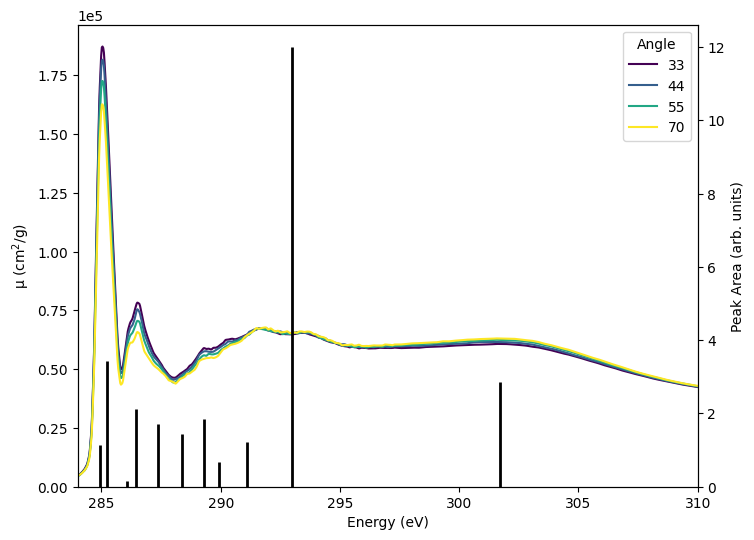

In [2]:
#  Load in the mu values


mu_files = list(Path.cwd().rglob("**/mu_*.csv"))
mu_dfs = []

for mu_file in mu_files:
    # Extract angle from filename (e.g., "mu_33deg.csv" -> "33")
    angle = mu_file.stem.split("_")[1].replace("deg", "")
    df = pd.read_csv(mu_file)
    df["Angle"] = int(angle)
    mu_dfs.append(df)

mu_df = pd.concat(mu_dfs, ignore_index=True)
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=mu_df, x="energy", y="mu", hue="Angle", ax=ax, palette="viridis")
ax.set_ylabel("μ (cm$^2$/g)")
#  set to use scientific notation
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax.set_xlabel("Energy (eV)")
ax.set_xlim(284, 310)
ax.set_ylim(0, None)
tabulated_peaks = [
    284.65,
    284.93,
    285.75,
    286.14,
    287.05,
    288.06,
    289.0,
    289.64,
    290.8,
    292.71,
    301.4,
]
tabulated_heights = [
    1.15,
    3.42,
    0.159,
    2.123,
    1.709,
    1.435,
    1.846,
    0.662,
    1.23,
    12.01,
    2.87,
]
ax2 = ax.twinx()
#  Add vertical lines for each peak
for peak, height in zip(tabulated_peaks, tabulated_heights, strict=True):
    ax2.vlines(x=peak + 0.3, color="k", linestyle="-", linewidth=2, ymin=0, ymax=height)

ax2.set_ylim(0, None)
ax2.set_ylabel(r"Peak Area (arb. units)")

(0.0, 0.006800255324799593)

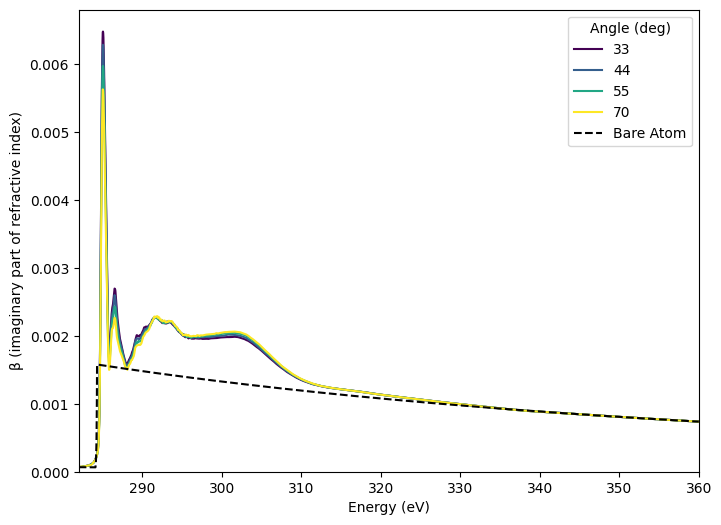

In [3]:
from periodictable.xsf import index_of_refraction

#  convert mass absorption to beta, the imaginary part of the refractive index
#  beta = (mu * lambda)
h = 4.135667696e-15  # Planck's constant in eV·s
c = 299792458  # Speed of light in m/s
mu_df["wavelength"] = (h * c) / (mu_df["energy"] * 1e-9)  # wavelength in nm

chemical_formula = "C54H36N4"
n = index_of_refraction(
    chemical_formula, energy=mu_df["energy"].loc[mu_df["Angle"] == 33] * 1e-3, density=1
)  # energy in keV

mu_df["beta"] = mu_df["mu"] * mu_df["wavelength"] * 1e-7 / (4 * np.pi)
#  plot beta vs energy for each angle
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=mu_df, x="energy", y="beta", hue="Angle", ax=ax, palette="viridis")
#  plot the bare atom beta = -n.imag
ax.plot(mu_df["energy"].loc[mu_df["Angle"] == 33], -n.imag, "k--", label="Bare Atom")
ax.legend(title="Angle (deg)")
ax.set_ylabel("β (imaginary part of refractive index)")
ax.set_xlabel("Energy (eV)")
ax.set_xlim(282, 360)
ax.set_ylim(0, None)

In [4]:
#  Save the beta values in normalized_nexafs.csv with columns Energy, Normalized Intensity, Angle
normalized_beta = mu_df[["energy", "beta", "Angle"]].rename(
    columns={"energy": "Energy", "beta": "Normalized Intensity"}
)
normalized_beta.to_csv("normalized_nexafs.csv", index=False)

# Ionization step edge


In [5]:
calc_path = Path("/home/hduva/projects/dft/tcta_flat")
#  grab all the tp.out files recursively
tp_files = list(calc_path.rglob("**/*tp.out"))
#  Iterate over each and run a quick scan though the File to read out the line that
#  Reads " Ionization potential ..." split at the = sign and grab the value at 1
ip_values = []
for tp_file in tp_files:
    with tp_file.open("r") as f:
        for line in f:
            if line.startswith(" Ionization potential"):
                ip_values.append(float(line.split("=")[1].strip().split()[0]))
energy_correction = [
    -2.0789666461294587,
    -1.8457671993563167,
    -1.8776436335463131,
    -2.064568802605095,
    -0.5019025930084808,
    -1.8125658520154388,
    -1.8963188086366927,
    0.9229806484480036,
    -1.860211144214361,
    -0.15548973718114212,
    -0.15555532292569296,
    -1.863333986289092,
    0.9944552043282329,
    -1.8969009482382262,
    -1.8004022053804647,
    -0.5033653406020449,
    -1.8783322458174325,
    -1.8466612484666598,
]
ip_values

[291.85351,
 290.7213,
 290.56136,
 290.55353,
 291.85211,
 290.6223,
 290.58289,
 290.69505,
 290.58328,
 290.42125,
 290.72093,
 290.55638,
 290.5626,
 290.38406,
 290.62246,
 291.95841,
 292.20367,
 290.70111]

In [6]:
np.array(ip_values) + np.array(energy_correction)

array([289.77454335, 288.8755328 , 288.68371637, 288.4889612 ,
       291.35020741, 288.80973415, 288.68657119, 291.61803065,
       288.72306886, 290.26576026, 290.56537468, 288.69304601,
       291.5570552 , 288.48715905, 288.82205779, 291.45504466,
       290.32533775, 288.85444875])

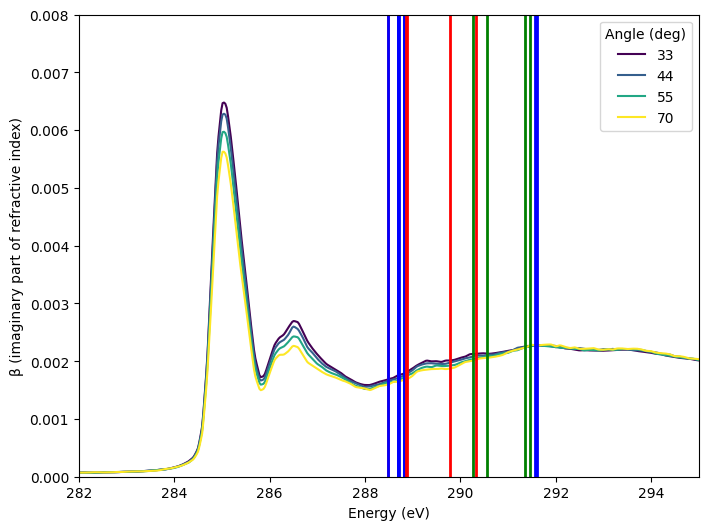

In [7]:
#  Draw in the dft calculated ionization energies
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=mu_df, x="energy", y="beta", hue="Angle", ax=ax, palette="viridis")
#  plot the ionization potentials as vertical lines
phynyl = [0, 1, 2, 3, 16, 17]
bent = [4, 9, 10, 15]
for i, ip in enumerate(np.array(ip_values) + np.array(energy_correction)):
    c = "r" if i in phynyl else "g" if i in bent else "b"
    ax.vlines(x=ip, color=c, linestyle="-", linewidth=2, ymin=0, ymax=0.5)
ax.set_xlim(282, 295)
ax.set_ylim(0, 8e-3)
ax.set_ylabel("β (imaginary part of refractive index)")
ax.set_xlabel("Energy (eV)")
ax.legend(title="Angle (deg)")
ip_corrected = np.array(ip_values) + np.array(energy_correction)

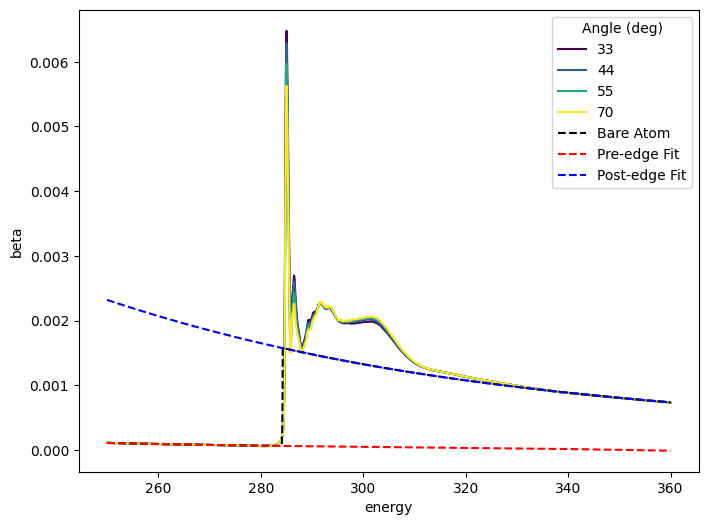

In [8]:
from scipy.special import erf
from periodictable.xsf import index_of_refraction
# Build an Ionization potential error function line shape for each of the corrected ip
# values and sum them to get a total line shape

#  Use numpy to perform a polynomial fit to the bare atom beta in the pre and post edge regions
# Get the 33-degree angle data
angle_33_data = mu_df[mu_df["Angle"] == 33]

# Recalculate n for the full energy range if needed

n_33 = index_of_refraction(
    chemical_formula, energy=angle_33_data["energy"] * 1e-3, density=1
)

pre_edge_energy = angle_33_data["energy"] < 284
post_edge_energy = angle_33_data["energy"] > 290

pre_edge_fit = np.polyfit(
    angle_33_data["energy"][pre_edge_energy],
    -n_33.imag[pre_edge_energy],
    deg=3,
)
post_edge_fit = np.polyfit(
    angle_33_data["energy"][post_edge_energy],
    -n_33.imag[post_edge_energy],
    deg=3,
)


# Create a function to evaluate the pre and post edge fits
def evaluate_fit(energy, fit_coeffs):
    return np.polyval(fit_coeffs, energy)


#  plot the results
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=mu_df, x="energy", y="beta", hue="Angle", ax=ax, palette="viridis")
#  plot the bare atom beta = -n.imag
ax.plot(
    angle_33_data["energy"],
    -n_33.imag,
    "k--",
    label="Bare Atom",
)
#  plot the pre and post edge fits
ax.plot(
    angle_33_data["energy"],
    evaluate_fit(angle_33_data["energy"], pre_edge_fit),
    "r--",
    label="Pre-edge Fit",
)
ax.plot(
    angle_33_data["energy"],
    evaluate_fit(angle_33_data["energy"], post_edge_fit),
    "b--",
    label="Post-edge Fit",
)
ax.legend(title="Angle (deg)")

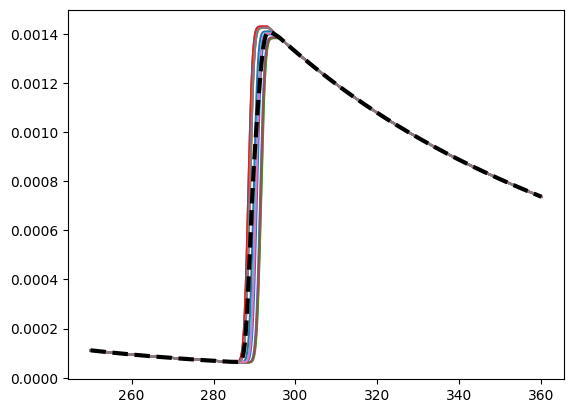

In [9]:
#  Build an error function centered at each ip value that stitches into the
#  pre and post edge fits after scaling to match the pre and post edge fits
combined_width = np.std(ip_corrected)  # Use the std dev of the ip values as the width
# Build each of the error function components


def ionization_potential_lineshape(
    energy, ip, width, pre_edge_coeffs=(-1, 0, 0), post_edge_coeffs=(-1, 0, 0)
):
    """
    Ionization potential lineshape.

    Parameters
    ----------
    energy : array-like
        The energy values where the lineshape is evaluated.
    ip : float
        The ionization potential value.
    width : float
        The width parameter for the error function.
    pre_edge_coeffs : tuple
        Coefficients for the pre-edge polynomial fit.
    post_edge_coeffs : tuple
        Coefficients for the post-edge polynomial fit.

    About
    -------
    This function generates the ionization potential lineshape based on the provided
    energy values, ionization potential, and width. It uses an error function to model
    the ionization absorption edge and stitches it into pre-edge and post-edge
    polynomial fits for a smooth transition.
    """
    decay_dist = 4 * width
    pre_edge_height = evaluate_fit(ip - decay_dist, pre_edge_coeffs)
    post_edge_height = evaluate_fit(ip + decay_dist, post_edge_coeffs)
    ef = 0.5 * (1 + erf((energy - ip) / width))
    lineshape = ef * post_edge_height + (1 - ef) * pre_edge_height
    # now replace the values after ip + decay_dist with the post edge fit
    lineshape[energy > (ip + decay_dist)] = evaluate_fit(
        energy[energy > (ip + decay_dist)], post_edge_coeffs
    )
    # now replace the values before ip - decay_dist with the pre edge fit
    lineshape[energy < (ip - decay_dist)] = evaluate_fit(
        energy[energy < (ip - decay_dist)], pre_edge_coeffs
    )
    return lineshape


energy_axis = angle_33_data["energy"].values
error_functions = []
for ip in ip_corrected:
    ef = ionization_potential_lineshape(
        energy_axis, ip, combined_width, pre_edge_fit, post_edge_fit
    )
    plt.plot(energy_axis, ef)  # Plot each error function
    error_functions.append(ef)
total_lineshape = np.sum(error_functions, axis=0) / len(error_functions)
plt.plot(energy_axis, total_lineshape, "k--", linewidth=3, label="Total Lineshape")

In [10]:
clustered_params = pd.read_csv("param_wave.csv")
clustered_params

,Unnamed: 0,E,OS,width,Cluster_ID,Original_Peak_Count,Atom,Index,osx,osy,osz,osc(r2),<r2>,Originating File,normalized_osx,normalized_osy,normalized_osz,normalized_magnitude,theta,normalized_os
0,0,286.477612,0.134675,0.212314,20,14,C9,1,0.000000,0.000000,0.041391,0.0000,31.4747,C9tp.out,0.000000,0.000000,1,1.0,0.000000,0.188892
1,1,286.816672,0.025065,0.212314,19,2,C13,3,-0.000000,0.000000,0.042222,0.0000,45.0507,C13tp.out,-0.000000,0.000000,1,1.0,0.000000,0.035156
2,2,287.327937,0.016861,0.212314,18,14,C9,2,0.000000,-0.000000,-0.018728,0.0000,50.2013,C9tp.out,0.000000,-0.000000,-1,1.0,0.000000,0.023649
3,3,287.978888,0.008375,0.212314,15,12,C7,3,0.000000,0.000000,-0.005821,0.0000,143.1887,C7tp.out,0.000000,0.000000,-1,1.0,15.000000,0.011747
4,4,288.275810,0.075312,0.212314,14,18,C13,9,0.012229,-0.011145,0.000000,0.0008,58.3506,C13tp.out,0.739105,-0.673590,0,1.0,50.000000,0.105631
5,5,288.604601,0.046155,0.212314,17,35,C10,9,-0.000000,0.000000,0.010290,0.0000,446.3229,C10tp.out,-0.000000,0.000000,1,1.0,36.000000,0.064736
6,6,289.049919,0.008277,0.212314,16,15,C15,14,0.007803,0.003083,-0.000000,0.0000,145.6115,C15tp.out,0.930038,0.367462,0,1.0,48.000000,0.011609
7,7,289.513415,0.021801,0.212314,11,17,C6,18,-0.006562,0.002448,0.000000,0.0000,280.9473,C6tp.out,-0.936926,0.349527,0,1.0,50.990712,0.030578
8,8,290.096667,0.013600,0.227204,13,39,C2,30,0.000000,-0.000000,0.005191,0.0000,206.3425,C2tp.out,0.000000,-0.000000,1,1.0,46.153846,0.019075
9,9,290.528179,0.010203,0.293525,12,20,C9,47,0.006742,0.000174,-0.000000,0.0001,558.5942,C9tp.out,0.999667,0.025800,0,1.0,58.500000,0.014310


# Building The Peaks


In [11]:
#  Grab the energy of the most prominent peak in the output clustered_params
prominent_peak = clustered_params.loc[0]
# Get the 55-degree angle data and find the energy at maximum mu
angle_55_data = mu_df[mu_df["Angle"] == 55]
max_mu_idx = angle_55_data["mu"].idxmax()
exp_peak_energy = angle_55_data.loc[max_mu_idx, "energy"]
print(f"Maximum mu at 55° occurs at energy: {exp_peak_energy} eV")
#  Calculate the energy shift needed to shift DFT to match experiment
energy_shift = exp_peak_energy - prominent_peak["E"]
energy_shift

Maximum mu at 55° occurs at energy: 285.0439883 eV


-1.4336236665861861

(284.0, 320.0)

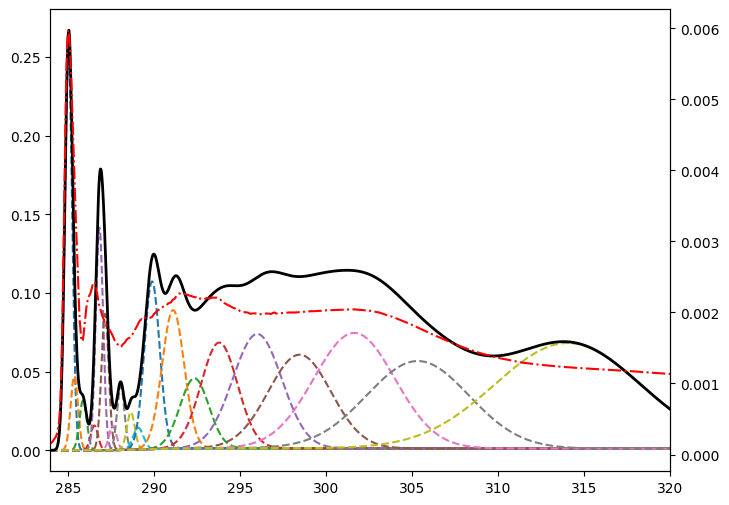

In [12]:
def peak(energy, center, amplitude, width):
    """Peak line shape."""
    sigma = (
        width  # / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to standard deviation
    )
    #  Cast amplituded into the peak area
    return (
        amplitude
        * np.exp(-0.5 * ((energy - center) / sigma) ** 2)
        / (sigma * np.sqrt(2 * np.pi))
    )


fig, ax = plt.subplots(figsize=(8, 6))
peaks = np.zeros_like(total_lineshape)
# Building The Peaks
for _, row in clustered_params.iterrows():
    os = (row["osx"] + row["osy"] + row["osz"]) / 3
    pk = peak(energy_axis, row["E"] + energy_shift, row["OS"], row["width"])
    ax.plot(
        energy_axis,
        pk + total_lineshape,
        linestyle="--",
        label=f"Peak at {row['E']:.2f} eV",
    )
    peaks += pk

ax.plot(
    energy_axis,
    peaks + total_lineshape,
    "k-",
    linewidth=2,
    label="Sum of Peaks + IP",
)
ax2 = ax.twinx()
ax2.plot(
    mu_df["energy"].loc[mu_df["Angle"] == 55],
    mu_df["beta"].loc[mu_df["Angle"] == 55],
    color="r",
    ls="-.",
    label="Experimental β at 55°",
)
ax.set_xlim(284, 320)

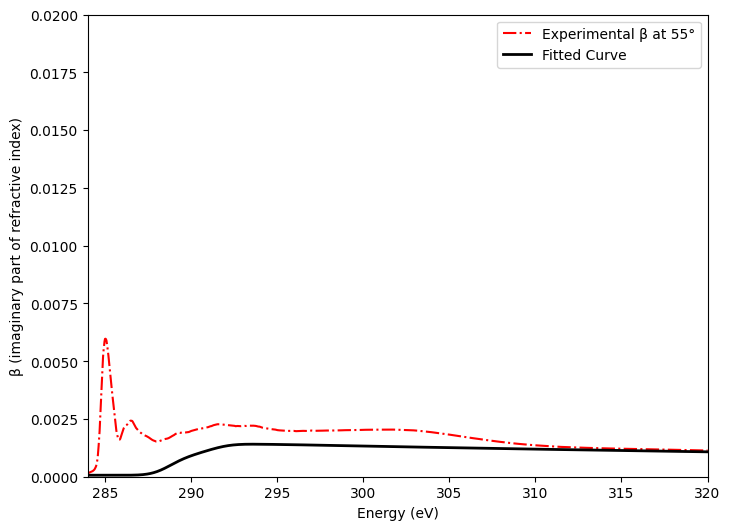

In [13]:
from scipy.optimize import curve_fit


def multi_gaussian_with_bare_atom(energy, *params):
    """
    Model function for multiple Gaussian peaks plus bare atom contribution.

    params should be:
    [center1, width1, amp1, center2, width2, amp2, ...]
    """
    from copy import deepcopy

    global total_lineshape
    # Remaining parameters are for Gaussian peaks
    peak_params = params[4:]
    n_peaks = len(peak_params) // 3
    result = deepcopy(total_lineshape)
    for i in range(n_peaks):
        center = peak_params[i * 3]
        width = peak_params[i * 3 + 1]
        amplitude = peak_params[i * 3 + 2]
        result += peak(energy, center, amplitude, width)

    return result


n_peaks = len(clustered_params)


p0 = []
lower_bounds = []
upper_bounds = []
for _, row in clustered_params.iterrows():
    center = row["E"] + energy_shift
    width = row["width"]
    amplitude = row["OS"]
    p0.extend([center, width, amplitude])
    lower_bounds.extend([center - 2, 0.1, 0])
    upper_bounds.extend([center + 2, 12, amplitude * 3])


popt, pcov = curve_fit(
    multi_gaussian_with_bare_atom,
    energy_axis,
    angle_55_data["beta"].values,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
)

fitted_curve = multi_gaussian_with_bare_atom(energy_axis, *popt)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(energy_axis, angle_55_data["beta"], "r-.", label="Experimental β at 55°")
ax.plot(energy_axis, fitted_curve, "k-", linewidth=2, label="Fitted Curve")
ax.set_xlim(284, 320)
ax.set_ylim(0, 0.02)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("β (imaginary part of refractive index)")
ax.legend()

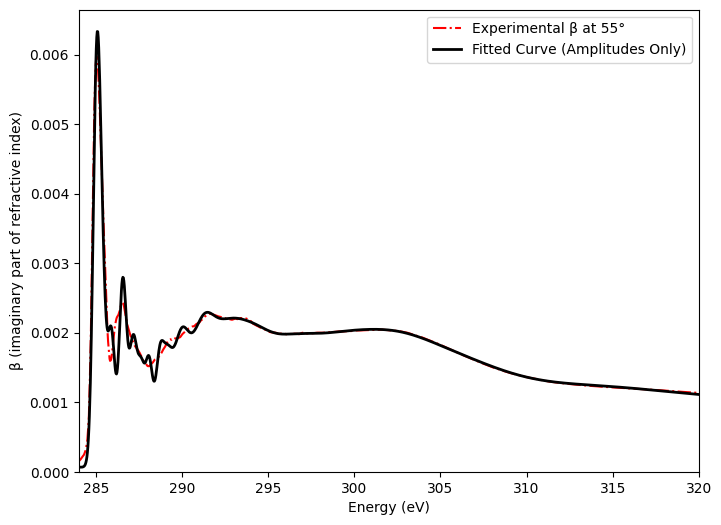

Fitted amplitudes: [0.00298543 0.00109812 0.00099851 0.00134797 0.00021098 0.00085145
 0.00064818 0.00068121 0.00055639 0.00064475 0.00110929 0.00136599
 0.00099439 0.00141715 0.00129883 0.00156952 0.00289348 0.00278572
 0.00096171]


In [14]:
from copy import deepcopy

from scipy.optimize import curve_fit

# Fix width and center values, fit only amplitudes first


def multi_gaussian_with_bare_atom_amplitudes_only(energy, *amplitudes):
    """
    Model function for multiple Gaussian peaks plus bare atom contribution.
    Only fitting amplitudes, with fixed centers and widths.
    """

    global total_lineshape
    result = deepcopy(total_lineshape)

    for i, amplitude in enumerate(amplitudes):
        row = clustered_params.iloc[i]
        center = row["E"] + energy_shift
        width = row["width"]
        result += peak(energy, center, amplitude, width)

    return result


# Initial guess for amplitudes only
amplitude_p0 = [row["OS"] for _, row in clustered_params.iterrows()]
amplitude_bounds = ([0] * len(amplitude_p0), [amp * 3 for amp in amplitude_p0])

# Fit only amplitudes
popt_amp, pcov_amp = curve_fit(
    multi_gaussian_with_bare_atom_amplitudes_only,
    energy_axis,
    angle_55_data["beta"].values,
    p0=amplitude_p0,
    bounds=amplitude_bounds,
)

# Plot results
fitted_curve_amp = multi_gaussian_with_bare_atom_amplitudes_only(energy_axis, *popt_amp)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(energy_axis, angle_55_data["beta"], "r-.", label="Experimental β at 55°")
ax.plot(
    energy_axis,
    fitted_curve_amp,
    "k-",
    linewidth=2,
    label="Fitted Curve (Amplitudes Only)",
)
ax.set_xlim(284, 320)
ax.set_ylim(0, None)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("β (imaginary part of refractive index)")
ax.legend()
plt.show()

print(f"Fitted amplitudes: {popt_amp}")

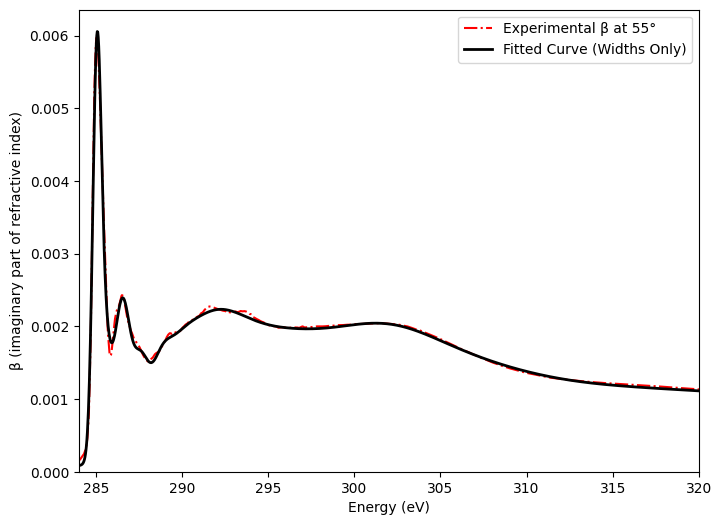

Fitted widths: [0.24288986 0.32395644 0.51568402 0.39540241 0.61023476 0.60987966
 0.4328158  2.03182706 0.5354728  0.98860754 1.29003806 1.67834785
 1.68022303 2.5145605  2.6320768  3.61554927 2.89488683 3.92764245
 8.80976463]


In [15]:
from scipy.optimize import curve_fit


# Fix center and amplitude values, fit only widths
def multi_gaussian_with_bare_atom_widths_only(energy, *widths):
    """
    Model function for multiple Gaussian peaks plus bare atom contribution.
    Only fitting widths, with fixed centers and amplitudes.
    """
    global total_lineshape
    result = deepcopy(total_lineshape)

    for i, width in enumerate(widths):
        row = clustered_params.iloc[i]
        center = row["E"] + energy_shift
        amplitude = popt_amp[i]  # Use fitted amplitudes from previous step
        result += peak(energy, center, amplitude, width)

    return result


# Initial guess for widths only - use the fitted widths from previous optimization
width_p0 = popt[1::3]  # Extract every 3rd element starting from index 1 (widths)
width_bounds = ([0.1] * len(width_p0), [12] * len(width_p0))

# Fit only widths
popt_width, pcov_width = curve_fit(
    multi_gaussian_with_bare_atom_widths_only,
    energy_axis,
    angle_55_data["beta"].values,
    p0=width_p0,
    bounds=width_bounds,
)

# Plot results
fitted_curve_width = multi_gaussian_with_bare_atom_widths_only(energy_axis, *popt_width)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(energy_axis, angle_55_data["beta"], "r-.", label="Experimental β at 55°")
ax.plot(
    energy_axis,
    fitted_curve_width,
    "k-",
    linewidth=2,
    label="Fitted Curve (Widths Only)",
)
ax.set_xlim(284, 320)
ax.set_ylim(0, None)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("β (imaginary part of refractive index)")
ax.legend()
plt.show()

print(f"Fitted widths: {popt_width}")

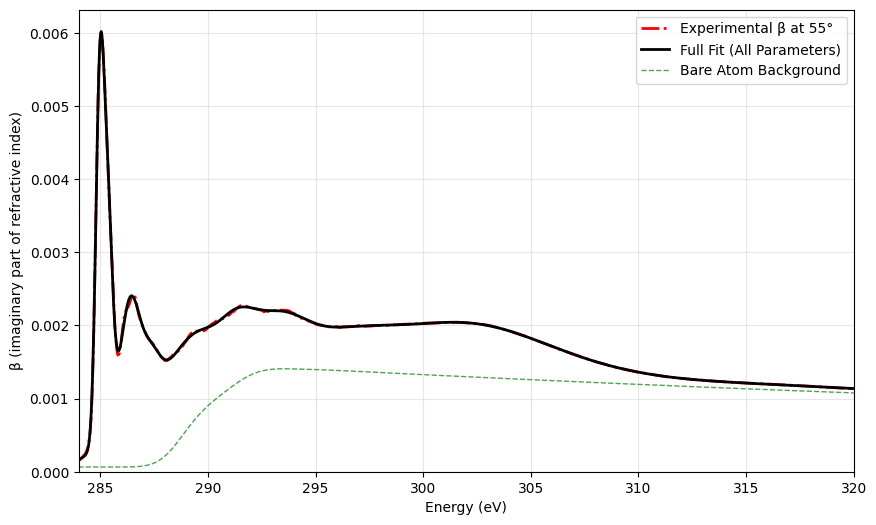

Final fitted parameters shape: (57,)
R-squared: 0.9999


In [16]:
# Fit width, amplitude, and center all together using the best parameters from previous steps
def multi_gaussian_with_bare_atom_all_params(energy, *params):
    """
    Model function for multiple Gaussian peaks plus bare atom contribution.
    Fitting all parameters: center, width, amplitude for each peak.
    """
    global total_lineshape
    result = deepcopy(total_lineshape)

    n_peaks = len(params) // 3
    for i in range(n_peaks):
        center = params[i * 3]
        width = params[i * 3 + 1]
        amplitude = params[i * 3 + 2]
        result += peak(energy, center, amplitude, width)

    return result


# Create initial parameters combining center, width, and amplitude
all_p0 = []
all_lower_bounds = []
all_upper_bounds = []

for i, row in clustered_params.iterrows():
    # Use fitted amplitudes and widths from previous optimizations
    center = row["E"] + energy_shift
    width = popt_width[i]
    amplitude = popt_amp[i]

    all_p0.extend([center, width, amplitude])
    all_lower_bounds.extend([center - 2, 0.1, 0])
    all_upper_bounds.extend([center + 2, 12, amplitude * 3])

# Fit all parameters together
popt_all, pcov_all = curve_fit(
    multi_gaussian_with_bare_atom_all_params,
    energy_axis,
    angle_55_data["beta"].values,
    p0=all_p0,
    bounds=(all_lower_bounds, all_upper_bounds),
    maxfev=10000,
)

# Generate fitted curve
fitted_curve_all = multi_gaussian_with_bare_atom_all_params(energy_axis, *popt_all)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    energy_axis,
    angle_55_data["beta"],
    "r-.",
    label="Experimental β at 55°",
    linewidth=2,
)
ax.plot(
    energy_axis, fitted_curve_all, "k-", linewidth=2, label="Full Fit (All Parameters)"
)
ax.plot(
    energy_axis,
    total_lineshape,
    "g--",
    linewidth=1,
    alpha=0.7,
    label="Bare Atom Background",
)

ax.set_xlim(284, 320)
ax.set_ylim(0, None)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("β (imaginary part of refractive index)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print(f"Final fitted parameters shape: {popt_all.shape}")
print(
    f"R-squared: {1 - np.sum((angle_55_data['beta'].values - fitted_curve_all) ** 2) / np.sum((angle_55_data['beta'].values - np.mean(angle_55_data['beta'].values)) ** 2):.4f}"
)

/home/hduva/projects/dft-learn/.venv/lib/python3.12/site-packages/scipy/optimize/_differentialevolution.py:486: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


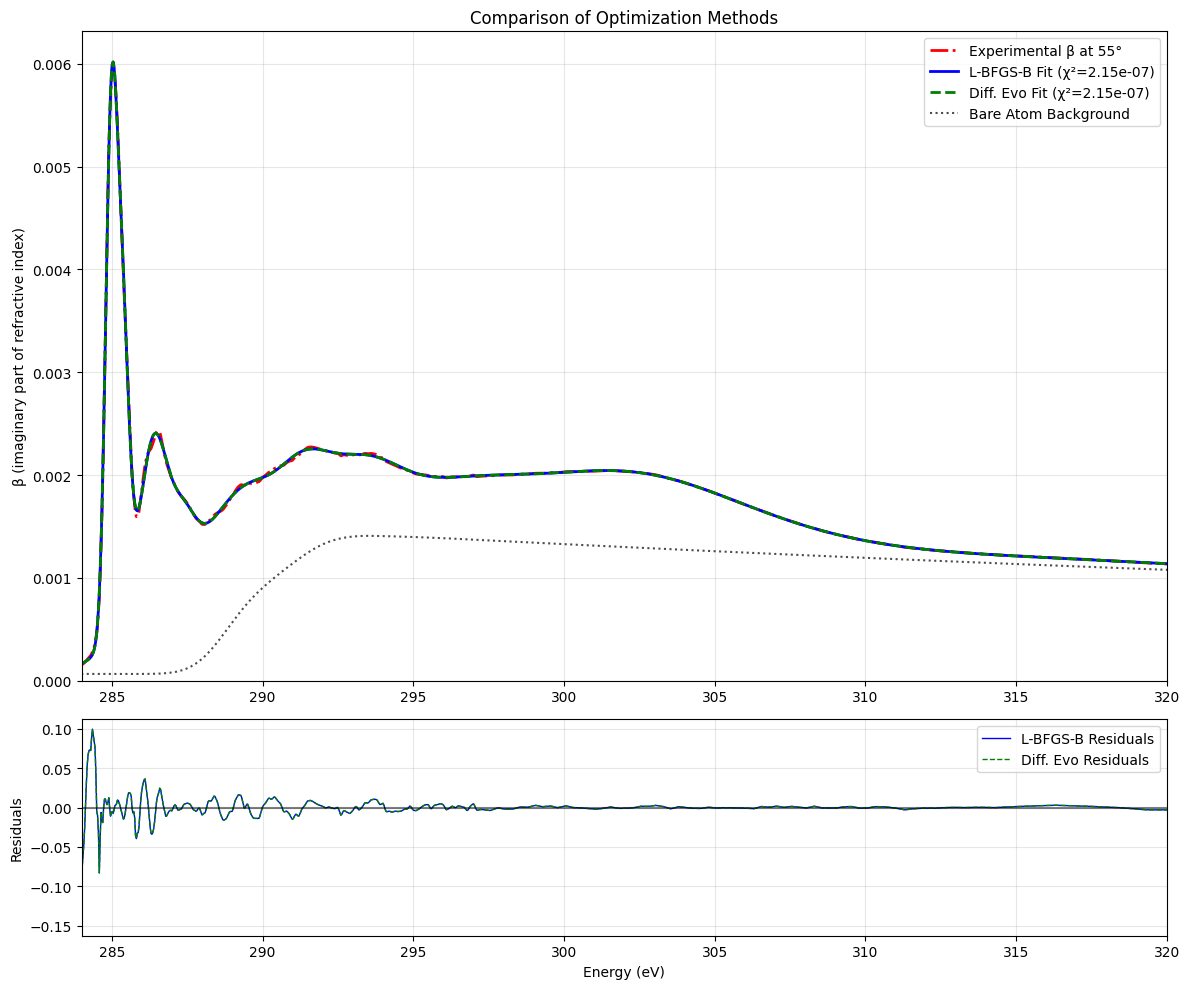


Best result from L-BFGS-B


In [ ]:
from scipy.optimize import minimize, differential_evolution
import time


def objective_function(params):
    """
    Objective function for fitting the multi-gaussian model to experimental data.

    Parameters
    ----------
    params : array-like
        Flattened array of parameters [center1, width1, amplitude1, center2, width2, amplitude2, ...]

    Returns
    -------
    float
        Sum of squared residuals between model and experimental data
    """
    try:
        fitted_curve = multi_gaussian_with_bare_atom_all_params(energy_axis, *params)
        residuals = angle_55_data["beta"].values - fitted_curve
        return np.sum(residuals**2)
    except:
        return 1e10  # Return large value if evaluation fails


result_lbfgs = minimize(
    objective_function,
    x0=popt_all,
    method="L-BFGS-B",
    bounds=list(zip(all_lower_bounds, all_upper_bounds)),
    options={"disp": False},
)

result_de = differential_evolution(
    objective_function,
    bounds=list(zip(all_lower_bounds, all_upper_bounds)),
    x0=popt_all,
    seed=42,
    disp=False,
    workers=-1,
)


# Plot comparison of fits
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 10), gridspec_kw={"height_ratios": [3, 1]}
)

# Main plot
ax1.plot(
    energy_axis,
    angle_55_data["beta"],
    "r-.",
    label="Experimental β at 55°",
    linewidth=2,
)

fitted_lbfgs = multi_gaussian_with_bare_atom_all_params(energy_axis, *result_lbfgs.x)
ax1.plot(
    energy_axis,
    fitted_lbfgs,
    "b-",
    linewidth=2,
    label=f"L-BFGS-B Fit (χ²={result_lbfgs.fun:.2e})",
)

fitted_de = multi_gaussian_with_bare_atom_all_params(energy_axis, *result_de.x)
ax1.plot(
    energy_axis,
    fitted_de,
    "g--",
    linewidth=2,
    label=f"Diff. Evo Fit (χ²={result_de.fun:.2e})",
)

# Background
ax1.plot(energy_axis, total_lineshape, "k:", alpha=0.7, label="Bare Atom Background")

ax1.set_xlim(284, 320)
ax1.set_ylim(0, None)
ax1.set_ylabel("β (imaginary part of refractive index)")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title("Comparison of Optimization Methods")

# Residuals plot
residuals_lbfgs = (angle_55_data["beta"].values - fitted_lbfgs) / angle_55_data[
    "beta"
].values
residuals_de = (angle_55_data["beta"].values - fitted_de) / angle_55_data["beta"].values

ax2.plot(energy_axis, residuals_lbfgs, "b-", linewidth=1, label="L-BFGS-B Residuals")
ax2.plot(energy_axis, residuals_de, "g--", linewidth=1, label="Diff. Evo Residuals")
ax2.axhline(y=0, color="k", linestyle="-", alpha=0.5)
ax2.set_xlim(284, 320)
ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel("Residuals")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store best result
best_result = result_lbfgs if result_lbfgs.fun < result_de.fun else result_de
best_method = (
    "L-BFGS-B" if result_lbfgs.fun < result_de.fun else "Differential Evolution"
)
print(f"\nBest result from {best_method}")

(284.0, 295.0)

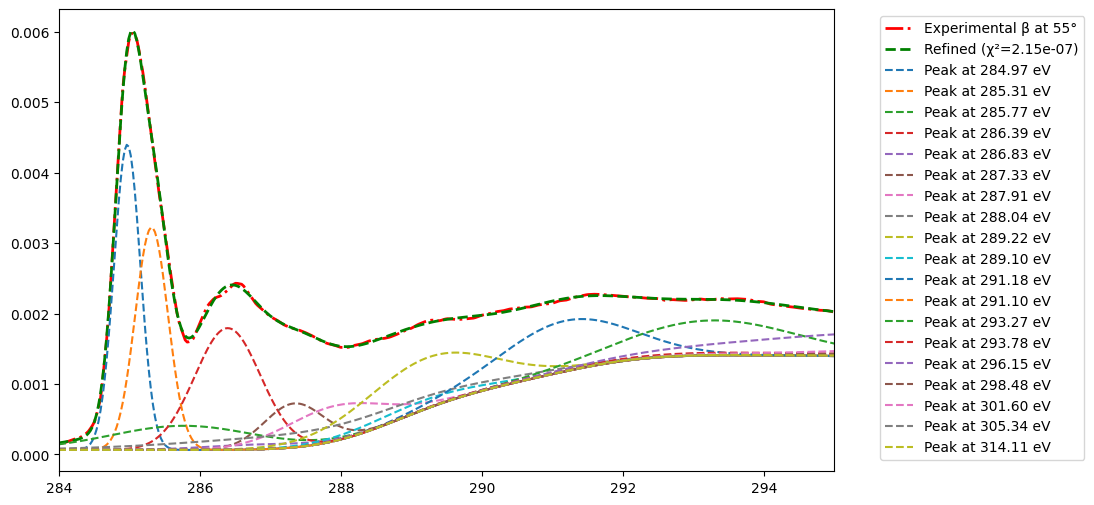

In [31]:
# Plot the differential evolution result showing each peak component
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    energy_axis,
    angle_55_data["beta"],
    "r-.",
    label="Experimental β at 55°",
    linewidth=2,
)
fitted_de = multi_gaussian_with_bare_atom_all_params(energy_axis, *result_de.x)
ax.plot(
    energy_axis,
    fitted_de,
    "g--",
    linewidth=2,
    label=f"Refined (χ²={result_de.fun:.2e})",
)
for i in range(n_peaks):
    center = result_de.x[i * 3]
    width = result_de.x[i * 3 + 1]
    amplitude = result_de.x[i * 3 + 2]
    pk = peak(energy_axis, center, amplitude, width)
    ax.plot(
        energy_axis,
        pk + total_lineshape,
        linestyle="--",
        label=f"Peak at {center:.2f} eV",
    )

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

ax.set_xlim(284, 295)

In [ ]:
def refined_mu_tensor(popt, clustered_params):
    """
    Use the refined parameters to build a mu tensor for each peak.

    Parameters
    ----------
    popt : array-like
        Optimized parameters from fitting [center1, width1, amplitude1, center2, width2
        , amplitude2, ...]
    clustered_params : DataFrame
        DataFrame containing the original clustered parameters with columns 'E', 'width',
        'OS', 'osx', 'osy', 'osz'.
    """
    n_peaks = len(popt) // 3
    mu_tensor = np.zeros((n_peaks, 3, 3))

    for i in range(n_peaks):
        center = popt[i * 3]
        width = popt[i * 3 + 1]
        amplitude = popt[i * 3 + 2]
        mu_tensor[i] = build_single_peak_mu_tensor(
            center, width, amplitude, clustered_params
        )

    return mu_tensor

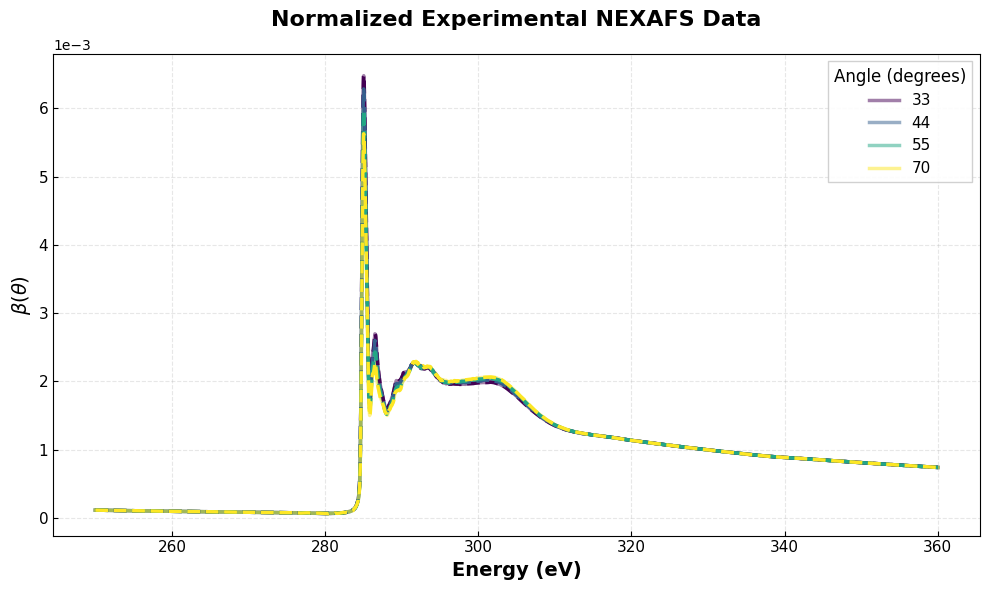

In [143]:
# Load the already normalized NEXAFS data
raw = pd.read_csv("normalized_nexafs.csv")
dft = pd.read_csv("normalized_nexafs.csv")

# Create a nice and pretty plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=raw,
    x="Energy",
    y="Normalized Intensity",
    hue="Angle",
    palette="viridis",
    linewidth=2.5,
    ax=ax,
    alpha=0.5,
)
sns.lineplot(
    data=dft,
    x="Energy",
    y="Normalized Intensity",
    hue="Angle",
    palette="viridis",
    linewidth=2.5,
    linestyle="--",
    ax=ax,
    legend=False,
)

# Customize the plot
ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Normalized Experimental NEXAFS Data", fontsize=16, fontweight="bold", pad=20
)
# Use scientific notation for y-axis
ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

# Customize legend
legend = ax.legend(
    title="Angle (degrees)",
    title_fontsize=12,
    fontsize=11,
    frameon=True,
    fancybox=False,
    shadow=False,
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.9)

# Add grid and styling
ax.grid(True, alpha=0.3, linestyle="--")
ax.tick_params(direction="in", labelsize=11)

# Adjust layout and save
plt.tight_layout()
plt.savefig("nexafs_normalized.png", dpi=300, bbox_inches="tight")
plt.show()

In [56]:
from scipy.ndimage import gaussian_filter1d

energy_step = round(dft["Energy"].diff().mean(), 2) / 10
#  create a common energy axis for all pairs
common_energy_steep = np.arange(
    round(dft["Energy"].min(), 2),
    round(dft["Energy"].max(), 2) + energy_step,
    energy_step,
)
common_energy = np.arange(
    round(dft["Energy"].min(), 2),
    round(dft["Energy"].max(), 2) + energy_step * 10,
    energy_step * 10,
)
interpolated_dfts = []
for angle in dft["Angle"].unique():
    angle_data = dft[dft["Angle"] == angle].copy()
    #  Apply a gaussian filter 1d to smooth the data before interpolation
    angle_data["Normalized Intensity"] = gaussian_filter1d(
        angle_data["Normalized Intensity"], sigma=1, radius=10
    )
    interpolated_dft = np.interp(
        common_energy_steep, angle_data["Energy"], angle_data["Normalized Intensity"]
    )
    interpolated_dft = gaussian_filter1d(interpolated_dft, sigma=10, radius=40)
    #  Re interpolate to the common energy axis
    interpolated_dft = np.interp(common_energy, common_energy_steep, interpolated_dft)
    #  Create a DataFrame for the interpolated data
    interpolated_dfts.append(
        pd.DataFrame(
            {
                "Energy": common_energy,
                "Normalized Intensity": interpolated_dft,
                "Angle": angle,
            }
        )
    )

dft = pd.concat(interpolated_dfts, ignore_index=True)
print(energy_step)

0.001


<Axes: xlabel='Energy', ylabel='Normalized Intensity'>

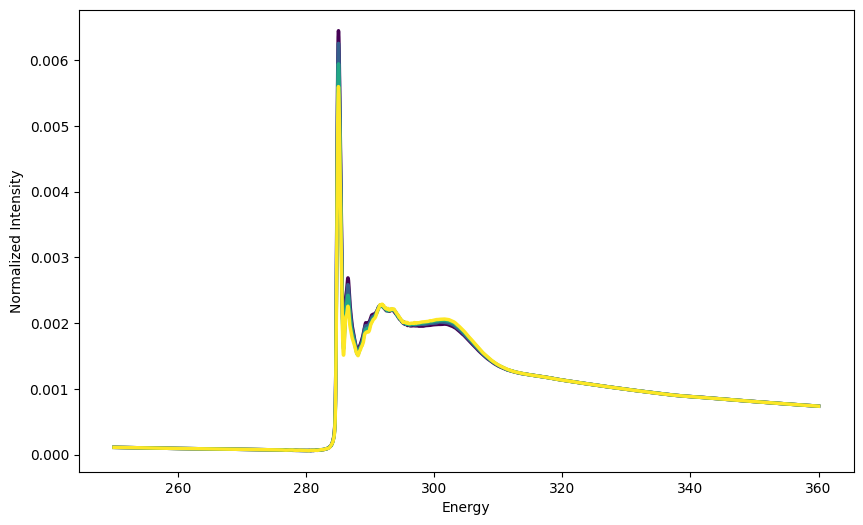

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=dft,
    x="Energy",
    y="Normalized Intensity",
    hue="Angle",
    palette="viridis",
    linewidth=2.5,
    linestyle="-",
    ax=ax,
    legend=False,
)

In [66]:
dft["Energy"].unique()

array([270.2 , 270.22, 270.24, ..., 329.96, 329.98, 330.  ], shape=(2991,))

(284.0, 310.0)

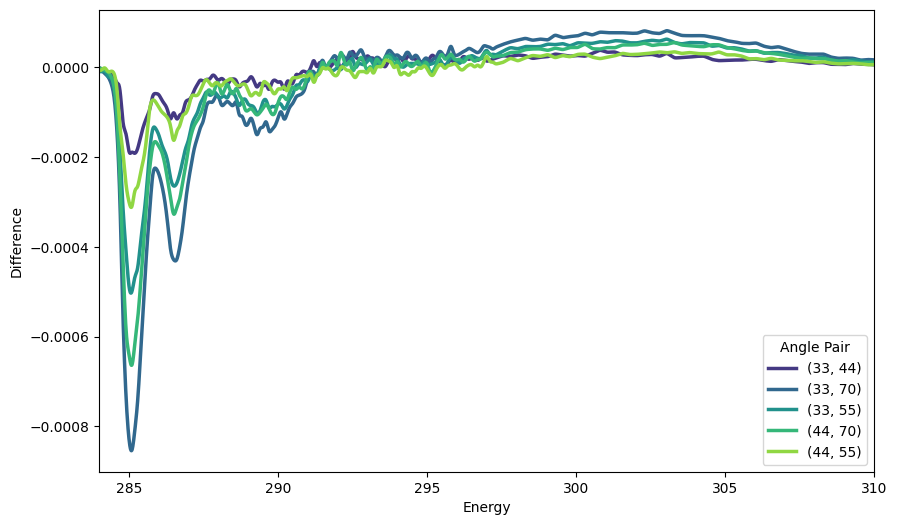

In [80]:
import itertools

#  Calculate the difference spectrum between each parining of high angles and low angles
angles = dft["Angle"].unique()
angle_pairs = [
    (low, high) for low, high in itertools.combinations(angles, 2) if low < high
]
# Compute the differnce between the dft_fit spectrum for each of these pairs and plot
fig, ax = plt.subplots(figsize=(10, 6))

diff_spectra = []
for low, high in angle_pairs:
    low_data = dft[dft["Angle"] == low]["Normalized Intensity"].values
    high_data = dft[dft["Angle"] == high]["Normalized Intensity"].values
    energy = dft[dft["Angle"] == low]["Energy"].values
    diff = high_data - low_data
    #  Apply a gaussian filter 1d to smooth the data before interpolation
    diff = gaussian_filter1d(diff, sigma=2, radius=5)
    #  Interpolate the difference spectrum to the common energy axis
    diff = np.interp(common_energy, energy, diff)
    diff_spectra.append(
        pd.DataFrame(
            {
                "Energy": energy,
                "Difference": diff,
                "Angle Pair": [f"{(int(low), int(high))}"] * len(energy),
            }
        )
    )

diff_df = pd.concat(diff_spectra, ignore_index=True)
sns.lineplot(
    data=diff_df,
    x="Energy",
    y="Difference",
    hue="Angle Pair",
    palette="viridis",
    linewidth=2.5,
    ax=ax,
)
ax.set_xlim(284, 310)

In [81]:
# Grab the energy associated with the maximum difference
max_diff = diff_df["Difference"].max()
diff_spec_max = diff_df[diff_df["Difference"] == diff_df["Difference"].max()][
    "Energy"
].values[0]

# Apply normalization using groupby
scaled_diff = (
    diff_df.groupby("Angle Pair")
    .apply(
        lambda group: group.assign(
            Difference=group["Difference"] / group["Difference"].max() * max_diff
        ),
    )
    .reset_index(level=0, drop=True)
)

# calculate the mean and std of the difference spectra
avg_diff = scaled_diff.groupby("Energy")["Difference"].median().reset_index()
std_diff = scaled_diff.groupby("Energy")["Difference"].std().reset_index()
avg_diff["Energy"].unique()

/tmp/ipykernel_20123/2286156583.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


array([250.  , 250.01, 250.02, ..., 359.98, 359.99, 360.  ])

In [85]:
#  grab the 33- 70 pair
avg_diff = scaled_diff[scaled_diff["Angle Pair"] == "(33, 70)"]

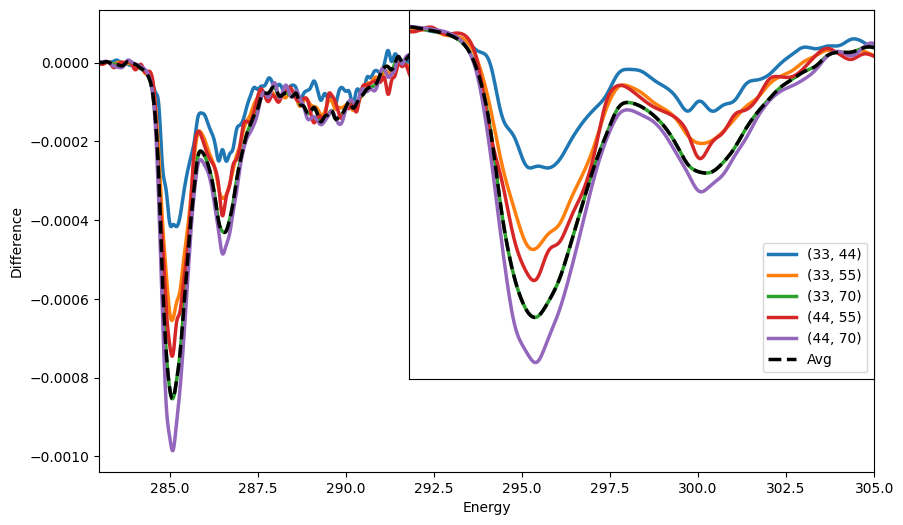

In [86]:
# Create the plot outside the groupby operation
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=scaled_diff,
    x="Energy",
    y="Difference",
    hue="Angle Pair",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=avg_diff,
    x="Energy",
    y="Difference",
    label="Average Difference Spectrum",
    linewidth=2.5,
    ax=ax,
    color="black",
    linestyle="--",
)

# Create an inset axis from 284 - 287
inset_ax = ax.inset_axes(
    [0.4, 0.2, 0.6, 0.8], xticklabels=[], yticklabels=[]
)  # [x, y, width, height]
inset_ax.set_xlim(284, 288)
sns.lineplot(
    data=scaled_diff[(scaled_diff["Energy"] >= 284) & (scaled_diff["Energy"] <= 288)],
    x="Energy",
    y="Difference",
    hue="Angle Pair",
    linewidth=2.5,
    ax=inset_ax,
)
sns.lineplot(
    data=avg_diff[(avg_diff["Energy"] >= 284) & (avg_diff["Energy"] <= 288)],
    x="Energy",
    y="Difference",
    label="Avg",
    linewidth=2.5,
    ax=inset_ax,
    color="black",
    linestyle="--",
)
# remove labels
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
# remove ticks
inset_ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)
# inset_ax.legend().remove()

# turn off the legend
ax.legend().remove()
ax.set_xlim(283, 305)
plt.show()

/tmp/ipykernel_20123/1789341915.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_diff["Difference"] = avg_diff["Difference"].apply(


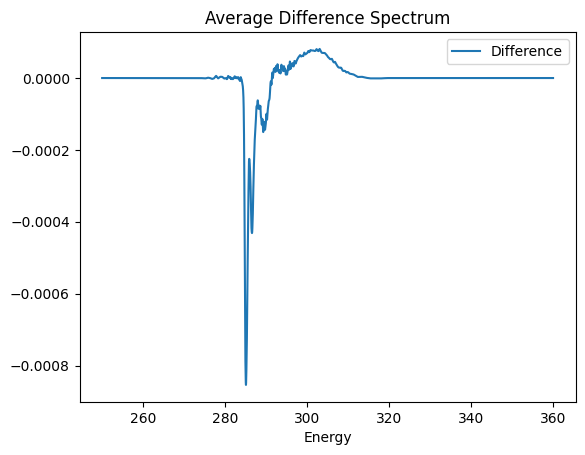

In [87]:
# Get sig figs of the first non-zero value and round the average difference spectrum
non_zero_values = avg_diff["Difference"][avg_diff["Difference"] != 0]
if len(non_zero_values) > 0:
    sig_figs = np.floor(np.log10(np.abs(non_zero_values.iloc[0])))
    decimal_places = max(0, int(abs(sig_figs) - 2))
else:
    decimal_places = 6  # Default precision for zero values

avg_diff["Difference"] = avg_diff["Difference"].apply(
    lambda x: round(x, decimal_places)
)
avg_diff.plot(
    x="Energy",
    y="Difference",
    title="Average Difference Spectrum",
)
avg_diff.to_csv("average_difference_spectrum.csv", index=False)

In [70]:
# Use the difference spectrum to calculate the in and out of plane optical constants
#  Grab the magic angle 55 degree spectrum
magic_angle = 55
oc_dfs = (
    dft[dft["Angle"] == magic_angle]
    .copy()
    .rename(columns={"Normalized Intensity": "βiso"})
).reset_index(drop=True)
# drop angle
oc_dfs = oc_dfs.drop(columns=["Angle"])
oc_dfs["Energy"] = oc_dfs["Energy"].round(3)
# Add the difference spectrum to the optical constants dataframe
oc_dfs["Difference"] = avg_diff["Difference"]
oc_dfs

,Energy,βiso,Difference
0,250.00,0.000112,-0.0
1,250.01,0.000112,-0.0
2,250.02,0.000112,-0.0
3,250.03,0.000112,-0.0
4,250.04,0.000112,-0.0
...,...,...,...
10996,359.96,0.000738,-0.0
10997,359.97,0.000738,-0.0
10998,359.98,0.000737,-0.0
10999,359.99,0.000737,-0.0


(283.0, 305.0)

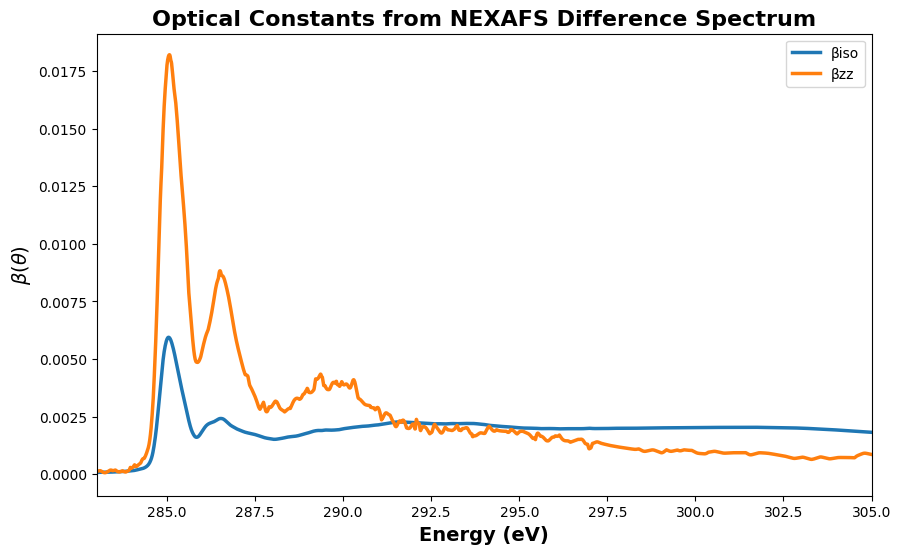

In [72]:
dipole_orientation = np.deg2rad(0)
dipole_energy = 284.93
dipole_iso = oc_dfs["βiso"].loc[oc_dfs["Energy"] == dipole_energy].values[0]
dipole_diff = oc_dfs["Difference"].loc[oc_dfs["Energy"] == dipole_energy].values[0]

scale_param = (3 * np.cos(dipole_orientation) ** 2 - 1) * dipole_iso / dipole_diff
oc_dfs["βzz"] = oc_dfs["βiso"] + scale_param * oc_dfs["Difference"]

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)

ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=16, fontweight="bold"
)
ax.set_xlim(283, 305)

(280.0, 286.0)

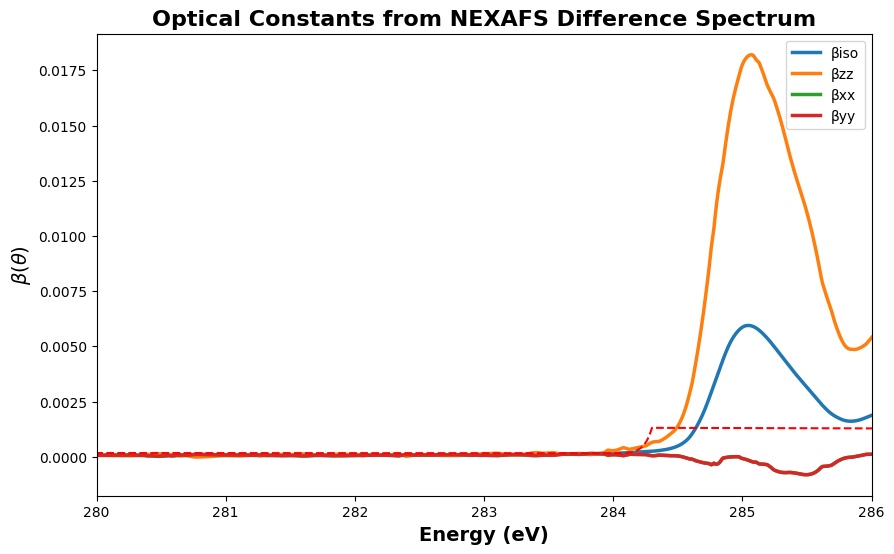

In [73]:
import periodictable.xsf as xsf

full_bare_atom = xsf.index_of_refraction(
    "C32H16N8Zn1", density=1, energy=oc_dfs["Energy"] * 1e-3
)

scale_in_plane = dipole_iso / dipole_diff
oc_dfs["βxx"] = oc_dfs["βiso"] - scale_in_plane * oc_dfs["Difference"]
oc_dfs["βyy"] = oc_dfs["βxx"]

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βyy",
    label="βyy",
    linewidth=2.5,
    ax=ax,
)

ax.plot(
    oc_dfs["Energy"],
    -full_bare_atom.imag,
    label="β from xsf",
    linestyle="--",
    color="red",
)

ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=16, fontweight="bold"
)
ax.set_xlim(280, 286)

Text(0.5, 1.0, 'Optical Constants with Polynomial Fit')

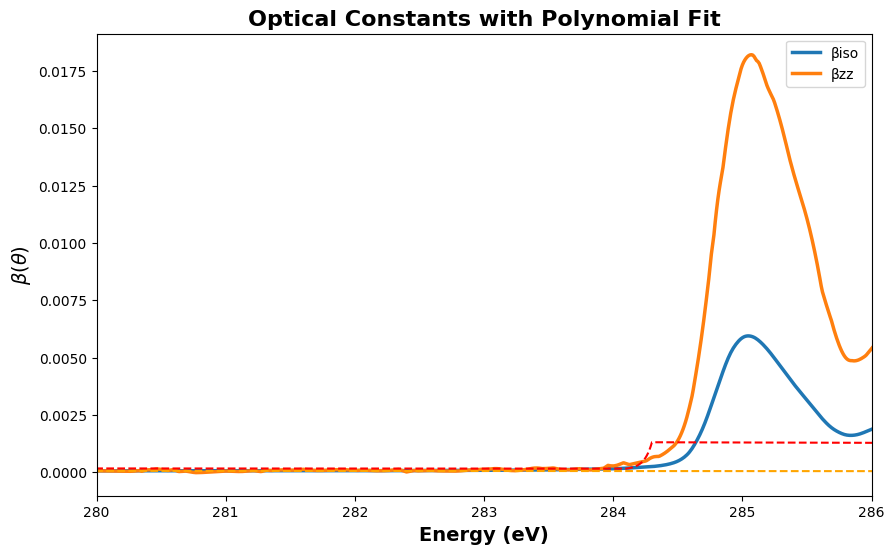

In [74]:
# Fit the pre edge region to a polynomial
pre_edge_region = oc_dfs[(oc_dfs["Energy"] <= 282)]
poly_fit = np.polyfit(pre_edge_region["Energy"], pre_edge_region["βzz"], 3)
poly_func = np.poly1d(poly_fit)
# Plot the data and the polynomial fit
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)
ax.plot(
    oc_dfs["Energy"],
    poly_func(oc_dfs["Energy"]),
    label="Polynomial Fit",
    linestyle="--",
    color="orange",
)
ax.plot(
    oc_dfs["Energy"],
    -full_bare_atom.imag,
    label="β from xsf",
    linestyle="--",
    color="red",
)
ax.set_xlim(280, 286)
ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title("Optical Constants with Polynomial Fit", fontsize=16, fontweight="bold")

(0.0, 0.001)

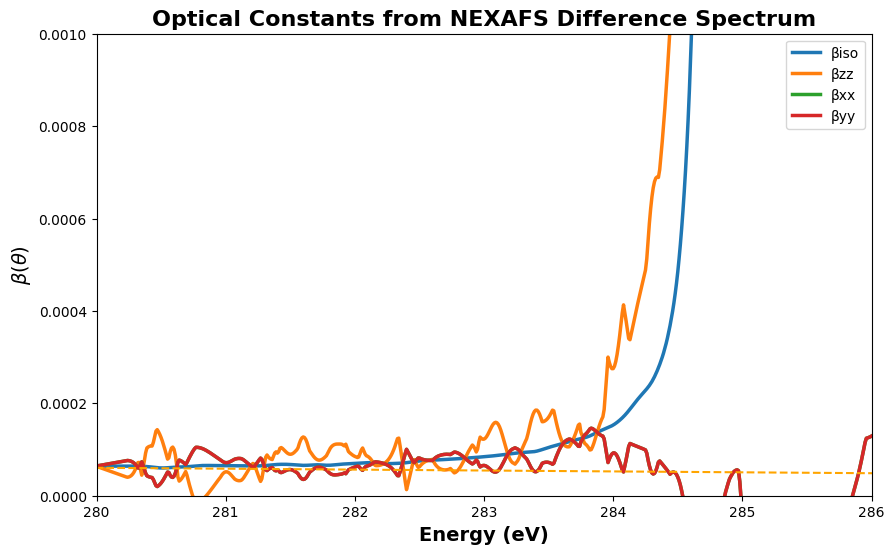

In [75]:
scale_in_plane_corrected = (dipole_iso - poly_func(dipole_energy)) / dipole_diff
oc_dfs["βxx"] = oc_dfs["βiso"] - scale_in_plane_corrected * oc_dfs["Difference"]
oc_dfs["βyy"] = oc_dfs["βxx"]

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βyy",
    label="βyy",
    linewidth=2.5,
    ax=ax,
)

ax.plot(
    oc_dfs["Energy"],
    poly_func(oc_dfs["Energy"]),
    label="Polynomial Fit",
    linestyle="--",
    color="orange",
)

ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=16, fontweight="bold"
)
ax.set_xlim(280, 286)
ax.set_ylim(0, 0.001)

(0.0, 0.001)

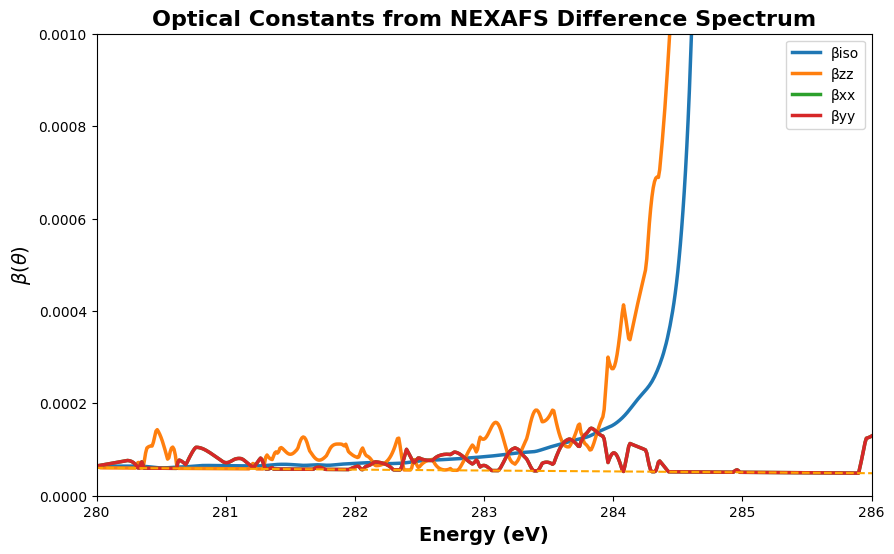

In [76]:
scale_in_plane_final = (
    dipole_iso * (1 - 0.5 * np.sin(dipole_orientation) ** 2) - poly_func(dipole_energy)
) / dipole_diff
oc_dfs["βxx"] = oc_dfs["βiso"] - scale_in_plane_final * oc_dfs["Difference"]
oc_dfs["βyy"] = oc_dfs["βxx"]

# Clip less than the polynomial fit
oc_dfs["βzz"] = np.clip(oc_dfs["βzz"], poly_func(oc_dfs["Energy"]), None)
oc_dfs["βxx"] = np.clip(oc_dfs["βxx"], poly_func(oc_dfs["Energy"]), None)
oc_dfs["βyy"] = np.clip(oc_dfs["βyy"], poly_func(oc_dfs["Energy"]), None)
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(data=oc_dfs, x="Energy", y="βyy", label="βyy", linewidth=2.5, ax=ax)

ax.plot(
    oc_dfs["Energy"],
    poly_func(oc_dfs["Energy"]),
    label="Polynomial Fit",
    linestyle="--",
    color="orange",
)

ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=16, fontweight="bold"
)
ax.set_xlim(280, 286)
ax.set_ylim(0, 0.001)

(283.0, 286.0)

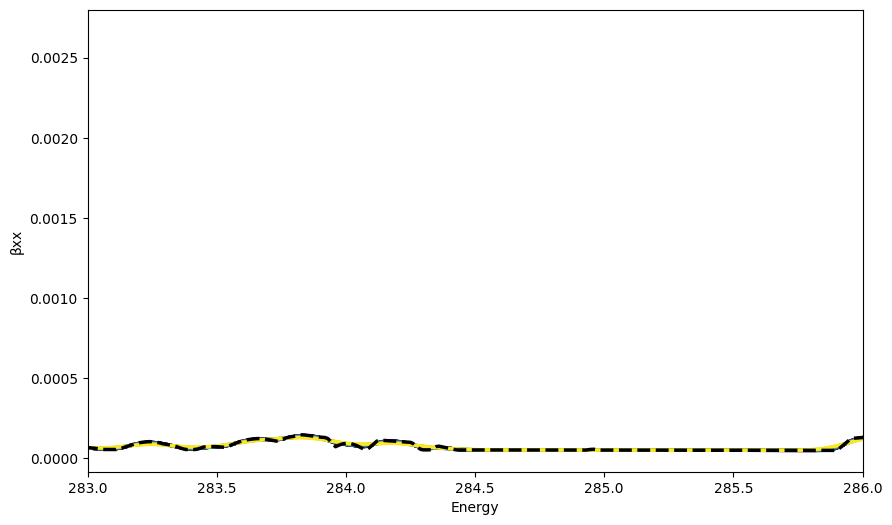

In [78]:
oc_filtered = oc_dfs.copy()
oc_filtered["sigma"] = 0
filter_sigms = [3, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 5, 6, 7, 8]
filtered_dfs = []
for sigm in filter_sigms:
    temp_df = oc_filtered.copy()
    # Apply a 1d gaussian filter to smooth the data
    temp_df["βiso"] = gaussian_filter1d(temp_df["βiso"], sigma=sigm)
    temp_df["βzz"] = gaussian_filter1d(temp_df["βzz"], sigma=sigm)
    temp_df["βxx"] = gaussian_filter1d(temp_df["βxx"], sigma=sigm)
    temp_df["βyy"] = gaussian_filter1d(temp_df["βyy"], sigma=sigm)
    temp_df["sigma"] = sigm
    filtered_dfs.append(temp_df)
oc_filtered = pd.concat(filtered_dfs, ignore_index=True)

# plot the optical constants with the rolling mean applied
fig, ax = plt.subplots(figsize=(10, 6))
# sns.lineplot(
#     data=oc_filtered,
#     x="Energy",
#     y="βzz",
#     hue="sigma",
#     palette="viridis",
#     linewidth=2.5,
#     ax=ax,
# )
# sns.lineplot(
#     data=oc_dfs,
#     x="Energy",
#     y="βzz",
#     label="βzz (no smoothing)",
#     linewidth=2.5,
#     ax=ax,
#     color="black",
#     linestyle="--",
# )
sns.lineplot(
    data=oc_filtered,
    x="Energy",
    y="βxx",
    hue="sigma",
    palette="viridis",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx (no smoothing)",
    linewidth=2.5,
    ax=ax,
    color="black",
    linestyle="--",
)
#  turn off the legend
ax.legend().remove()
ax.set_xlim(283, 286)
# ax.set_ylim(0.00015, 0.0002)

Text(0.5, 1.0, 'Optical Constants from NEXAFS Difference Spectrum')

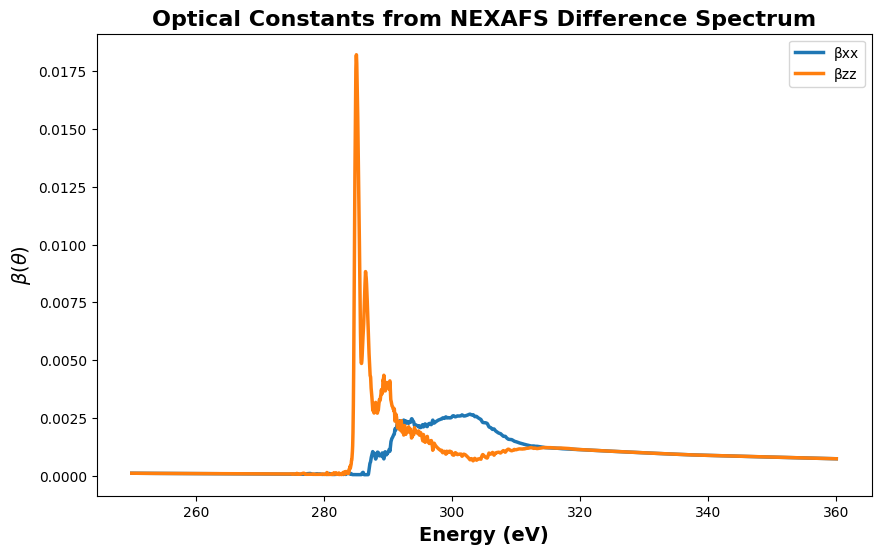

In [79]:
# Lets use the 3.5 beta xx trace
oc_dfs["βxx"] = oc_filtered[oc_filtered["sigma"] == 3.5]["βxx"].values
oc_dfs["βyy"] = oc_dfs["βxx"]

# plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)

ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=16, fontweight="bold"
)

In [105]:
oc_dfs.to_csv("optical_constants_beta.csv", index=False)

(283.0, 305.0)

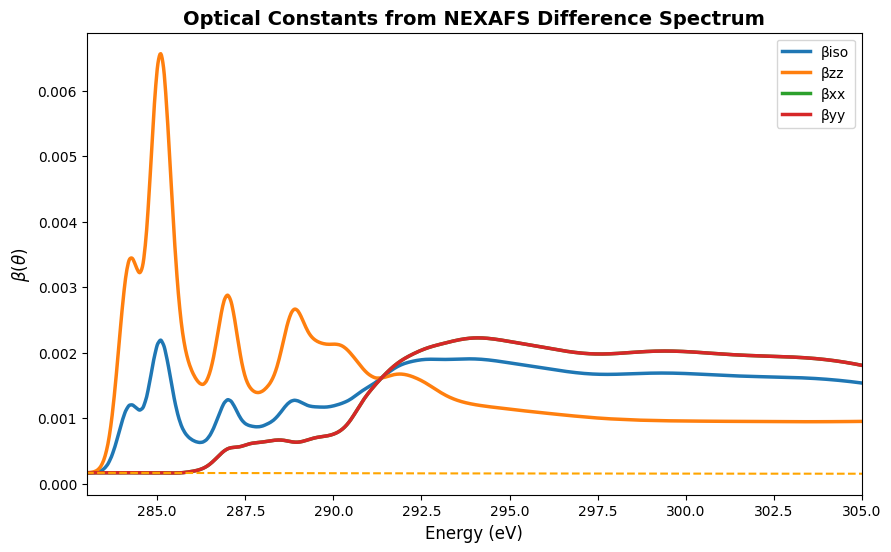

In [106]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(data=oc_dfs, x="Energy", y="βyy", label="βyy", linewidth=2.5, ax=ax)

ax.plot(
    oc_dfs["Energy"],
    poly_func(oc_dfs["Energy"]),
    label="Polynomial Fit",
    linestyle="--",
    color="orange",
)

ax.set_xlabel("Energy (eV)", fontsize=12)
ax.set_ylabel(r"$\beta (\theta)$", fontsize=12)
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=14, fontweight="bold"
)
ax.set_xlim(283, 305)

In [117]:
from kkcalc import kk

# Now we need to use the kramers kronig relations to calculate the real part of the refractive index
calc_e = kk.kk_calculate_real(
    oc_dfs[["Energy", "βzz"]].values,
    "C32H16N8Zn1",
    input_data_type="beta",
    load_options=None,
    merge_points=[oc_dfs["Energy"].min(), oc_dfs["Energy"].max()],
    add_background=False,
    curve_tolerance=0.01,
    curve_recursion=100,
)
calc_o = kk.kk_calculate_real(
    oc_dfs[["Energy", "βxx"]].values,
    "C32H16N8Zn1",
    input_data_type="beta",
    load_options=None,
    merge_points=[oc_dfs["Energy"].min(), oc_dfs["Energy"].max()],
    add_background=False,
    curve_tolerance=0.01,
    curve_recursion=100,
)

stoichiometry = kk.data.ParseChemicalFormula("C32H16N8Zn1")
mass = kk.data.calculate_FormulaMass(stoichiometry)

δxx = kk.data.convert_data(
    calc_o[:, [0, 1]], "ASF", "refractive_index", Density=1, Formula_Mass=mass
)
δzz = kk.data.convert_data(
    calc_e[:, [0, 1]], "ASF", "refractive_index", Density=1, Formula_Mass=mass
)
βxx = kk.data.convert_data(
    calc_o[:, [0, 2]], "ASF", "beta", Density=1, Formula_Mass=mass
)
βzz = kk.data.convert_data(
    calc_e[:, [0, 2]], "ASF", "beta", Density=1, Formula_Mass=mass
)

Text(0.5, 0, 'Energy (eV)')

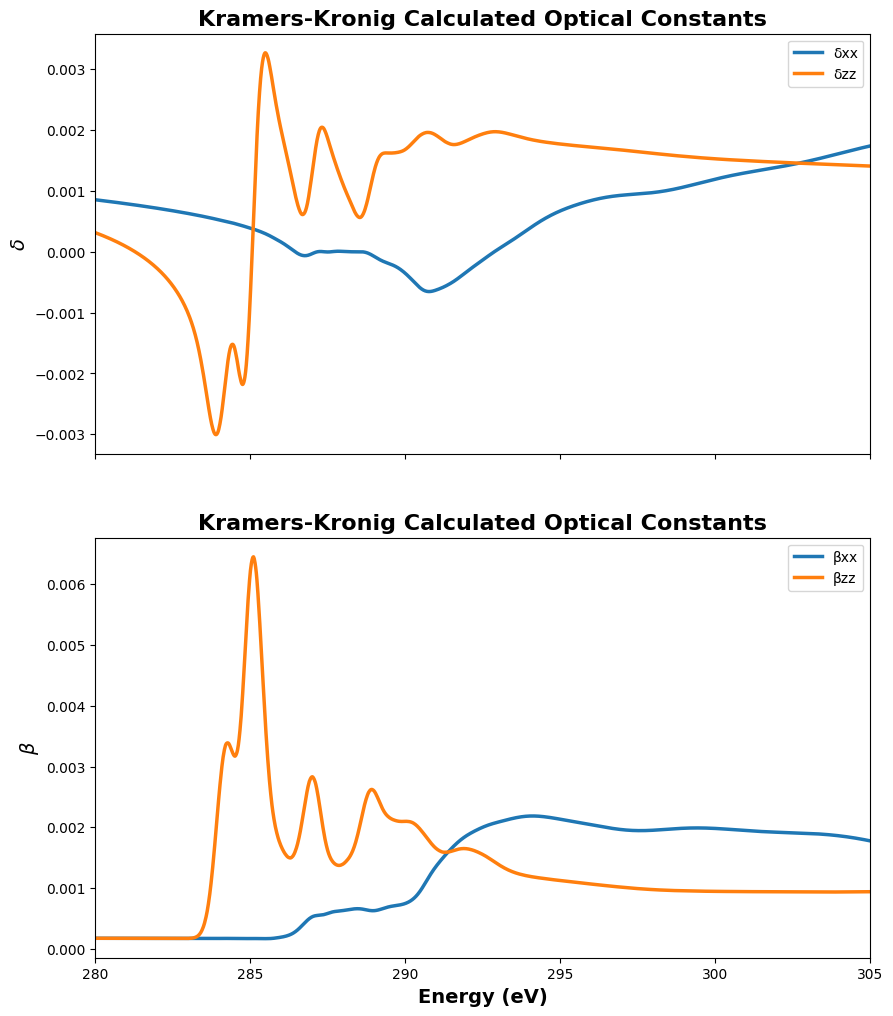

In [127]:
# Grab the unique energies
energies = np.unique(np.concatenate([δxx[:, 0], δzz[:, 0], βxx[:, 0], βzz[:, 0]]))
# Create a DataFrame with the energies and the corresponding values
oc_kk = pd.DataFrame(
    {
        "Energy": energies,
        "δxx": np.interp(energies, δxx[:, 0], δxx[:, 1]),
        "δzz": np.interp(energies, δzz[:, 0], δzz[:, 1]),
        "βxx": np.interp(energies, βxx[:, 0], βxx[:, 1]),
        "βzz": np.interp(energies, βzz[:, 0], βzz[:, 1]),
    }
)

fig, (delta_ax, beta_ax) = plt.subplots(
    2, 1, figsize=(10, 12), sharex=True, gridspec_kw={"height_ratios": [1, 1]}
)

# zoom into the energy range of 280 - 305 eV
delta_ax.set_xlim(280, 305)
beta_ax.set_xlim(280, 305)
filter = (oc_kk["Energy"] >= 280) & (oc_kk["Energy"] <= 305)

sns.lineplot(
    data=oc_kk[filter],
    x="Energy",
    y="δxx",
    label="δxx",
    linewidth=2.5,
    ax=delta_ax,
)
sns.lineplot(
    data=oc_kk[filter],
    x="Energy",
    y="δzz",
    label="δzz",
    linewidth=2.5,
    ax=delta_ax,
)
delta_ax.set_ylabel(r"$\delta$", fontsize=14, fontweight="bold")
delta_ax.set_title(
    "Kramers-Kronig Calculated Optical Constants", fontsize=16, fontweight="bold"
)

sns.lineplot(
    data=oc_kk[filter],
    x="Energy",
    y="βxx",
    label="βxx",
    linewidth=2.5,
    ax=beta_ax,
)
sns.lineplot(
    data=oc_kk[filter],
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=beta_ax,
)

beta_ax.set_ylabel(r"$\beta$", fontsize=14, fontweight="bold")
beta_ax.set_title(
    "Kramers-Kronig Calculated Optical Constants", fontsize=16, fontweight="bold"
)
beta_ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")

In [128]:
#  Rename deltas to use xx and zz, and betas to use ixx and izz
oc_kk.rename(
    columns={
        "Energy": "energy",
        "δxx": "n_xx",
        "δzz": "n_zz",
        "βxx": "n_ixx",
        "βzz": "n_izz",
    }
).to_csv("optical_constants.csv", index=False)

# Load Optical Constants for Constraints and OOC instantiation


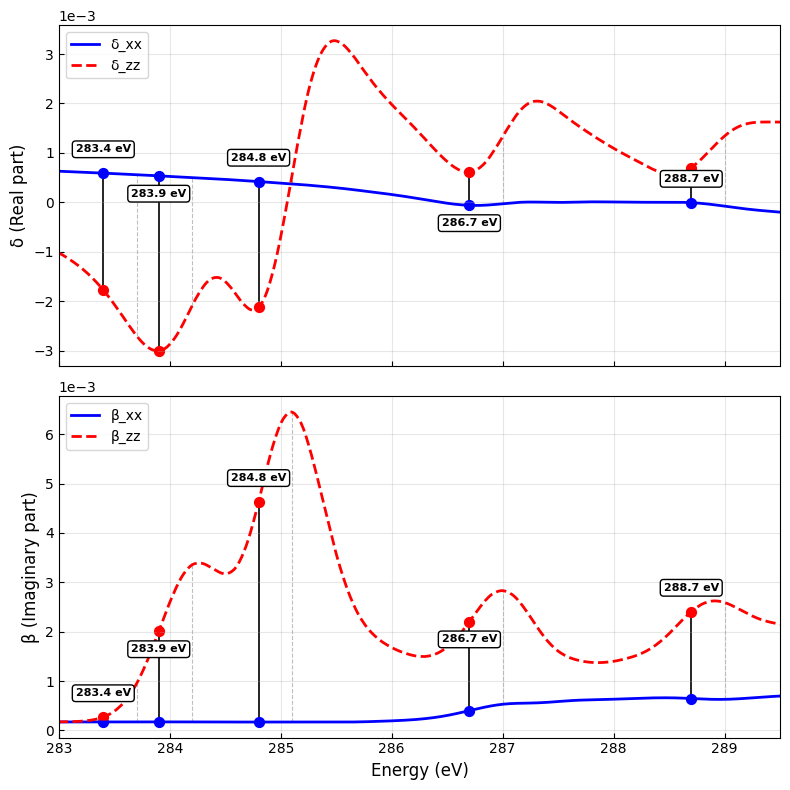

In [141]:
ooc = pd.read_csv("optical_constants.csv")
# We need to
energy_batches = [
    [],
    [
        250.0,
        275.0,
        280.0,
        281.0,
        281.2,
        281.4,
        281.6,
        281.8,
        282.0,
        282.3,
        282.5,
        282.7,
        282.9,
        283.1,
        283.3,
        283.5,
        283.7,
        284.2,
        285.1,
        287.0,
        289.0,
    ],
]


def ooc_func(energy):
    """Get optical constants for a given energy."""
    #  return the interpolated values for a given energy
    n_xx = np.interp(energy, ooc["energy"], ooc["n_xx"])
    n_zz = np.interp(energy, ooc["energy"], ooc["n_zz"])
    n_ixx = np.interp(energy, ooc["energy"], ooc["n_ixx"])
    n_izz = np.interp(energy, ooc["energy"], ooc["n_izz"])
    return n_xx, n_zz, n_ixx, n_izz


# Create a cleaner plot with better layout - stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Zoomed view of real parts around absorption edge
mask = (ooc["energy"] >= 245) & (ooc["energy"] <= 295)
ax1.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_xx"], "b-", linewidth=2, label="δ_xx"
)
ax1.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_zz"], "r--", linewidth=2, label="δ_zz"
)
ax1.set_ylabel("δ (Real part)", fontsize=12)
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)
ax1.tick_params(direction="in")
ax1.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

# Zoomed view of imaginary parts around absorption edge
ax2.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_ixx"], "b-", linewidth=2, label="β_xx"
)
ax2.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_izz"], "r--", linewidth=2, label="β_zz"
)
ax2.set_ylabel("β (Imaginary part)", fontsize=12)
ax2.set_xlabel("Energy (eV)", fontsize=12)
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)
ax2.tick_params(direction="in")
ax2.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

en_shift = -0.3

# Draw vertical lines at the measurement energies
for i, e in enumerate(energy_batches[1]):
    if e < 283.7:
        continue
    n_xx, n_zz, n_ixx, n_izz = ooc_func(e)
    n_xx_shifted, n_zz_shifted, n_ixx_shifted, n_izz_shifted = ooc_func(e + en_shift)
    ax1.vlines(
        e,
        ymin=min(n_xx, n_zz),
        ymax=max(n_xx, n_zz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )
    ax2.vlines(
        e,
        ymin=min(n_ixx, n_izz),
        ymax=max(n_ixx, n_izz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )

    # Energy-shifted energies (solid red lines)
    ax1.vlines(
        e + en_shift,
        ymin=min(n_xx_shifted, n_zz_shifted),
        ymax=max(n_xx_shifted, n_zz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )
    ax2.vlines(
        e + en_shift,
        ymin=min(n_ixx_shifted, n_izz_shifted),
        ymax=max(n_ixx_shifted, n_izz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )

    ax1.scatter(
        e + en_shift,
        n_xx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"δ_xx at {e + en_shift} eV",
    )
    ax1.scatter(
        e + en_shift,
        n_zz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"δ_zz at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_ixx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"β_xx at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_izz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"β_zz at {e + en_shift} eV",
    )
    # if the energy is >= 283.7 eV annotate the point with a box and bold text
    if e >= 283.7:
        ax1.annotate(
            f"{e + en_shift:.1f} eV",
            (e + en_shift, n_xx_shifted),
            textcoords="offset points",
            xytext=(0, 15 if i % 2 == 0 else -15),
            ha="center",
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
            fontweight="bold",
        )
        ax2.annotate(
            f"{e + en_shift:.1f} eV",
            (e + en_shift, n_izz_shifted),
            textcoords="offset points",
            xytext=(0, 15 if i % 2 == 0 else -15),
            ha="center",
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
            fontweight="bold",
        )

# Set consistent x-axis limits
for ax in [ax1, ax2]:
    ax.set_xlim(283, 289.5)

# Adjust layout and show
plt.tight_layout()
plt.show()

# offset_energies = [energy_batches[0] + en_shift, energy_batches[1] + en_shift]

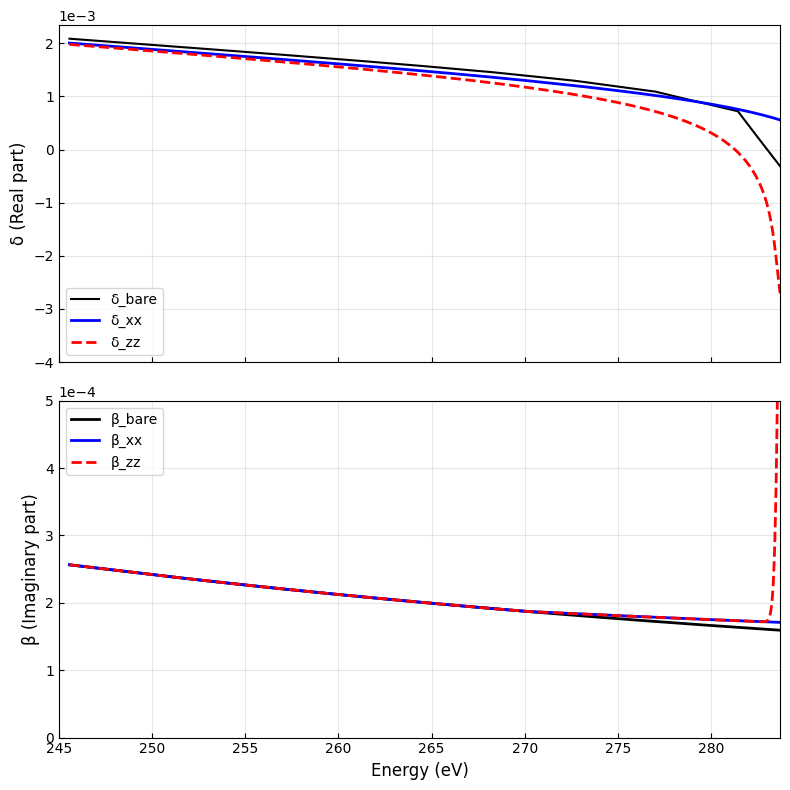

In [130]:
import periodictable.xsf as xsf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
# Zoomed view of real parts around absorption edge
mask = (ooc["energy"] >= 245) & (ooc["energy"] <= 284.5)
bare_atom = xsf.index_of_refraction(
    "C32H16N8Zn1", density=1, energy=ooc.loc[mask, "energy"] * 1e-3
)
ax1.plot(
    ooc.loc[mask, "energy"], 1 - bare_atom.real, "k", linewidth=1.5, label="δ_bare"
)
ax1.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_xx"], "b-", linewidth=2, label="δ_xx"
)
ax1.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_zz"], "r--", linewidth=2, label="δ_zz"
)
ax1.set_ylabel("δ (Real part)", fontsize=12)

ax1.grid(True, alpha=0.3)
ax1.tick_params(direction="in")
ax1.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

ax1.set_ylim((-4e-3))
ax1.legend(loc="lower left")

ax2.plot(ooc.loc[mask, "energy"], -bare_atom.imag, "k", linewidth=2, label="β_bare")
ax2.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_ixx"], "b-", linewidth=2, label="β_xx"
)
ax2.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_izz"], "r--", linewidth=2, label="β_zz"
)
ax2.set_ylabel("β (Imaginary part)", fontsize=12)
ax2.set_xlabel("Energy (eV)", fontsize=12)
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)
ax2.tick_params(direction="in")
ax2.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
ax2.set_ylim(0, 5e-4)

en_shift = -0.3

# Draw vertical lines at the measurement energies
for i, e in enumerate(energy_batches[1]):
    if e not in energy_batches[0]:
        continue
    n_xx, n_zz, n_ixx, n_izz = ooc_func(e)
    n_xx_shifted, n_zz_shifted, n_ixx_shifted, n_izz_shifted = ooc_func(e + en_shift)
    ax1.vlines(
        e,
        ymin=min(n_xx, n_zz),
        ymax=max(n_xx, n_zz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )
    ax2.vlines(
        e,
        ymin=min(n_ixx, n_izz),
        ymax=max(n_ixx, n_izz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )

    # Energy-shifted energies (solid red lines)
    ax1.vlines(
        e + en_shift,
        ymin=min(n_xx_shifted, n_zz_shifted),
        ymax=max(n_xx_shifted, n_zz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )
    ax2.vlines(
        e + en_shift,
        ymin=min(n_ixx_shifted, n_izz_shifted),
        ymax=max(n_ixx_shifted, n_izz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )

    ax1.scatter(
        e + en_shift,
        n_xx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"δ_xx at {e + en_shift} eV",
    )
    ax1.scatter(
        e + en_shift,
        n_zz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"δ_zz at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_ixx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"β_xx at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_izz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"β_zz at {e + en_shift} eV",
    )

    ax1.annotate(
        f"{e + en_shift:.1f} eV",
        (e + en_shift, n_xx_shifted),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        fontweight="bold",
    )
    ax2.annotate(
        f"{e + en_shift:.1f} eV",
        (e + en_shift, n_ixx_shifted),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        fontweight="bold",
    )

# Set consistent x-axis limits
for ax in [ax1, ax2]:
    ax.set_xlim(245, 283.7)

# Adjust layout and show
plt.tight_layout()
plt.show()

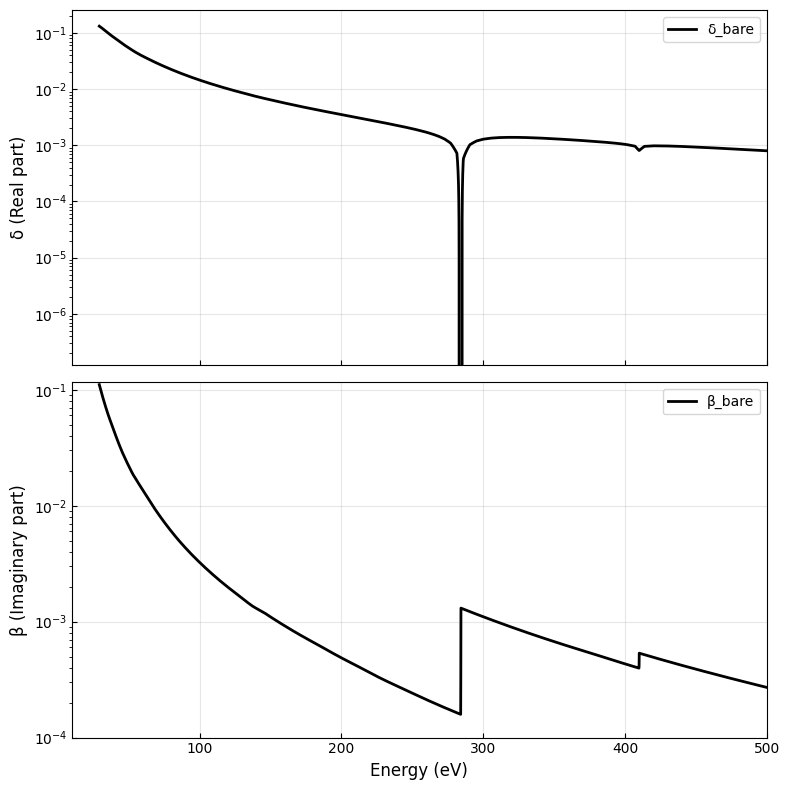

In [132]:
full_bare_atom = xsf.index_of_refraction(
    "C32H16N8Zn1", density=1, energy=ooc["energy"] * 1e-3
)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

ax1.plot(ooc["energy"], 1 - full_bare_atom.real, "k", linewidth=2, label="δ_bare")
ax1.set_ylabel("δ (Real part)", fontsize=12)
ax1.set_yscale("log")
ax1.grid(True, alpha=0.3)
ax1.tick_params(direction="in")
ax1.legend()

ax2.plot(ooc["energy"], -full_bare_atom.imag, "k", linewidth=2, label="β_bare")
ax2.set_ylabel("β (Imaginary part)", fontsize=12)
ax2.set_xlabel("Energy (eV)", fontsize=12)
ax2.set_ylim((1e-4, None))
ax2.set_yscale("log")
ax2.grid(True, alpha=0.3)
ax2.tick_params(direction="in")
ax2.legend()

for ax in [ax1, ax2]:
    ax.set_xlim(10, 500)

plt.tight_layout()
plt.show()

In [47]:
def calculate_normalization_factors(normalization_energy=250):
    """
    Calculate normalization factors for optical constants.

    Parameters:
    -----------
    normalization_energy : float, optional
        Energy in eV to use for normalization (default: 250)

    Returns:
    --------
    tuple : (xx_norm, zz_norm, ixx_norm, izz_norm)
        Normalization factors for n_xx, n_zz, n_ixx, n_izz
    """
    # Get optical constants at normalization energy
    nxx, nzz, nixx, nizz = ooc_func(normalization_energy)

    # Calculate bare atom optical constants
    bare_atom = xsf.index_of_refraction(
        "C32H16N8Zn1", density=1, energy=normalization_energy * 1e-3
    )

    # Calculate normalization factors
    xx_norm = (1 - bare_atom.real) / nxx
    zz_norm = (1 - bare_atom.real) / nzz
    ixx_norm = -bare_atom.imag / nixx
    izz_norm = -bare_atom.imag / nizz

    print(
        f"Normalization factors:\n"
        f"n_xx: {xx_norm:.4f}, n_zz: {zz_norm:.4f}, n_ixx: {ixx_norm:.4f}, n_izz: {izz_norm:.4f}"
    )

    return xx_norm, zz_norm, ixx_norm, izz_norm


# Calculate normalization factors
xx_norm, zz_norm, ixx_norm, izz_norm = calculate_normalization_factors()

Normalization factors:
n_xx: 0.9567, n_zz: 0.9262, n_ixx: 0.8619, n_izz: 0.8619


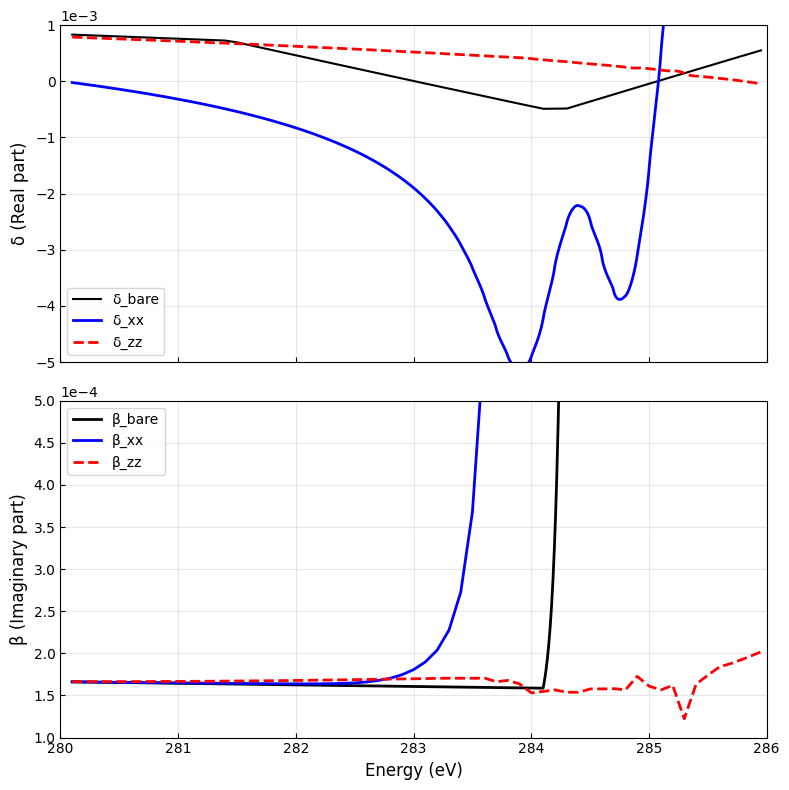

In [38]:
import periodictable.xsf as xsf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
# Zoomed view of real parts around absorption edge
mask = (ooc["energy"] >= 280) & (ooc["energy"] <= 286)
bare_atom = xsf.index_of_refraction(
    "C32H16N8Zn1", density=1, energy=ooc.loc[mask, "energy"] * 1e-3
)
ax1.plot(
    ooc.loc[mask, "energy"], 1 - bare_atom.real, "k", linewidth=1.5, label="δ_bare"
)
ax1.plot(
    ooc.loc[mask, "energy"],
    ooc.loc[mask, "n_xx"] * xx_norm,
    "b-",
    linewidth=2,
    label="δ_xx",
)
ax1.plot(
    ooc.loc[mask, "energy"],
    ooc.loc[mask, "n_zz"] * zz_norm,
    "r--",
    linewidth=2,
    label="δ_zz",
)
ax1.set_ylabel("δ (Real part)", fontsize=12)

ax1.grid(True, alpha=0.3)
ax1.tick_params(direction="in")
ax1.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

ax1.set_ylim((-5e-3, 1e-3))
ax1.legend(loc="lower left")

ax2.plot(ooc.loc[mask, "energy"], -bare_atom.imag, "k", linewidth=2, label="β_bare")
ax2.plot(
    ooc.loc[mask, "energy"],
    ooc.loc[mask, "n_ixx"] * ixx_norm,
    "b-",
    linewidth=2,
    label="β_xx",
)
ax2.plot(
    ooc.loc[mask, "energy"],
    ooc.loc[mask, "n_izz"] * izz_norm,
    "r--",
    linewidth=2,
    label="β_zz",
)
ax2.set_ylabel("β (Imaginary part)", fontsize=12)
ax2.set_xlabel("Energy (eV)", fontsize=12)
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)
ax2.tick_params(direction="in")
ax2.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
ax2.set_ylim(1e-4, 5e-4)

en_shift = -0.3

# Draw vertical lines at the measurement energies
for i, e in enumerate(energy_batches[1]):
    if e not in energy_batches[0]:
        continue
    n_xx, n_zz, n_ixx, n_izz = ooc_func(e)
    n_xx_shifted, n_zz_shifted, n_ixx_shifted, n_izz_shifted = ooc_func(e + en_shift)
    n_xx *= xx_norm
    n_zz *= zz_norm
    n_ixx *= ixx_norm
    n_izz *= izz_norm
    n_xx_shifted *= xx_norm
    n_zz_shifted *= zz_norm
    n_ixx_shifted *= ixx_norm
    n_izz_shifted *= izz_norm
    ax1.vlines(
        e,
        ymin=min(n_xx, n_zz),
        ymax=max(n_xx, n_zz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )
    ax2.vlines(
        e,
        ymin=min(n_ixx, n_izz),
        ymax=max(n_ixx, n_izz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )

    # Energy-shifted energies (solid red lines)
    ax1.vlines(
        e + en_shift,
        ymin=min(n_xx_shifted, n_zz_shifted),
        ymax=max(n_xx_shifted, n_zz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )
    ax2.vlines(
        e + en_shift,
        ymin=min(n_ixx_shifted, n_izz_shifted),
        ymax=max(n_ixx_shifted, n_izz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )

    ax1.scatter(
        e + en_shift,
        n_xx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"δ_xx at {e + en_shift} eV",
    )
    ax1.scatter(
        e + en_shift,
        n_zz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"δ_zz at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_ixx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"β_xx at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_izz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"β_zz at {e + en_shift} eV",
    )

    ax1.annotate(
        f"{e + en_shift:.1f} eV",
        (e + en_shift, n_xx_shifted),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        fontweight="bold",
    )
    ax2.annotate(
        f"{e + en_shift:.1f} eV",
        (e + en_shift, n_ixx_shifted),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        fontweight="bold",
    )

# Set consistent x-axis limits
for ax in [ax1, ax2]:
    ax.set_xlim(280, 286)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [39]:
# apply the normalization factors to the optical constant df and then save it
ooc["n_xx"] *= xx_norm
ooc["n_zz"] *= zz_norm
ooc["n_ixx"] *= ixx_norm
ooc["n_izz"] *= izz_norm
ooc.to_csv("normalized_optical_constants.csv", index=False)